In [1]:
import xarray as xr
import os
import glob
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.abspath('../src-double-gyre'))
sys.path.append(os.path.abspath('../src'))
warnings.filterwarnings("ignore")
from helpers.collection_of_experiments import CollectionOfExperiments
from plot_helpers import *

%load_ext autoreload
%autoreload 3

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/R4-sensitivity', additional_subfolder='output')

In [4]:
for RR in ['R4', 'R64', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0']:
    ds.remesh(RR, 'R1')
    ds.remesh(RR, 'R2')
    if RR != 'R4':
        ds.remesh(RR, 'R4')

Experiment R4 coarsegrained to R1 is created. Its identificator=R4_R1
Experiment R4 coarsegrained to R2 is created. Its identificator=R4_R2
Experiment R64 coarsegrained to R1 is created. Its identificator=R64_R1
Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R1 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R1
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R2 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R2
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R4 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R4


In [5]:
ds.remesh('R2', 'R1')

Experiment R2 coarsegrained to R1 is created. Its identificator=R2_R1


# Choosing the coarsest mesh possible for optimization problem
We choose coarse resolution 1 degree mostly to be prepared for global ocean model

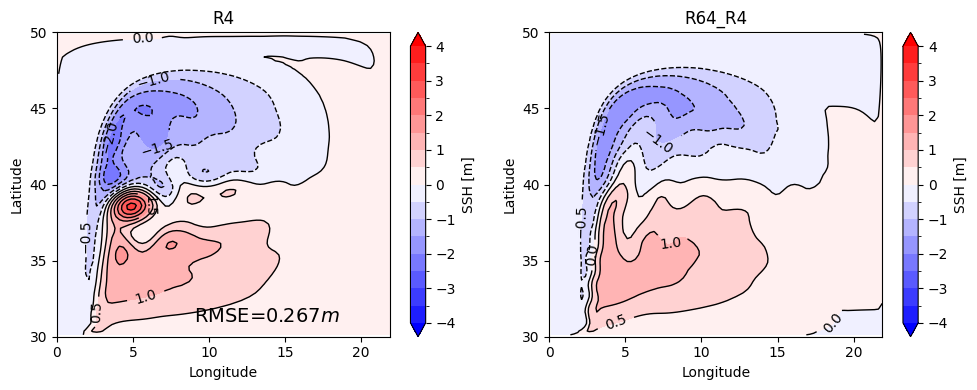

In [65]:
ds.plot_ssh(['R4', 'R64_R4'])

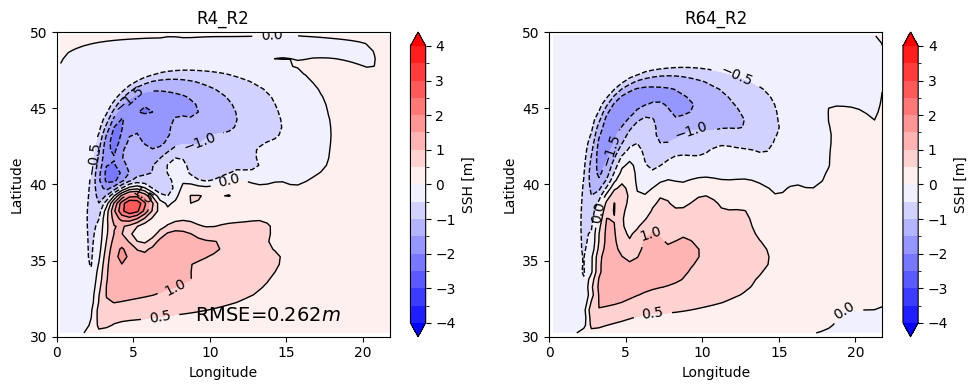

In [66]:
ds.plot_ssh(['R4_R2', 'R64_R2'])

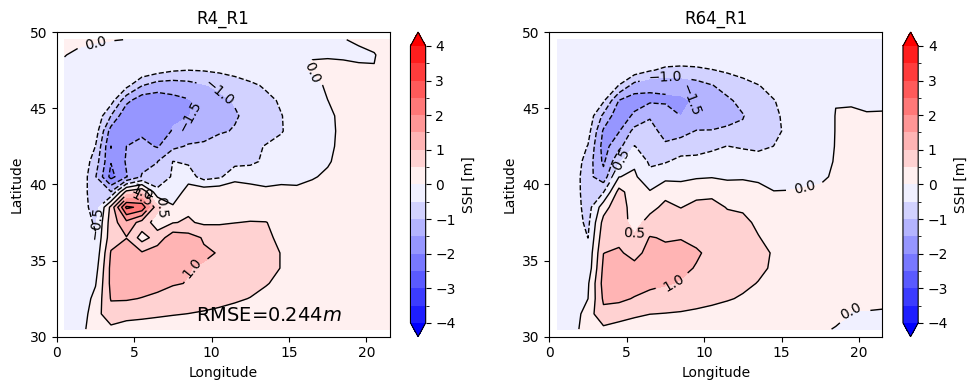

In [67]:
ds.plot_ssh(['R4_R1', 'R64_R1'])

In [114]:
ds['R4_R1'].ssh_mean.data.ravel().shape

(440,)

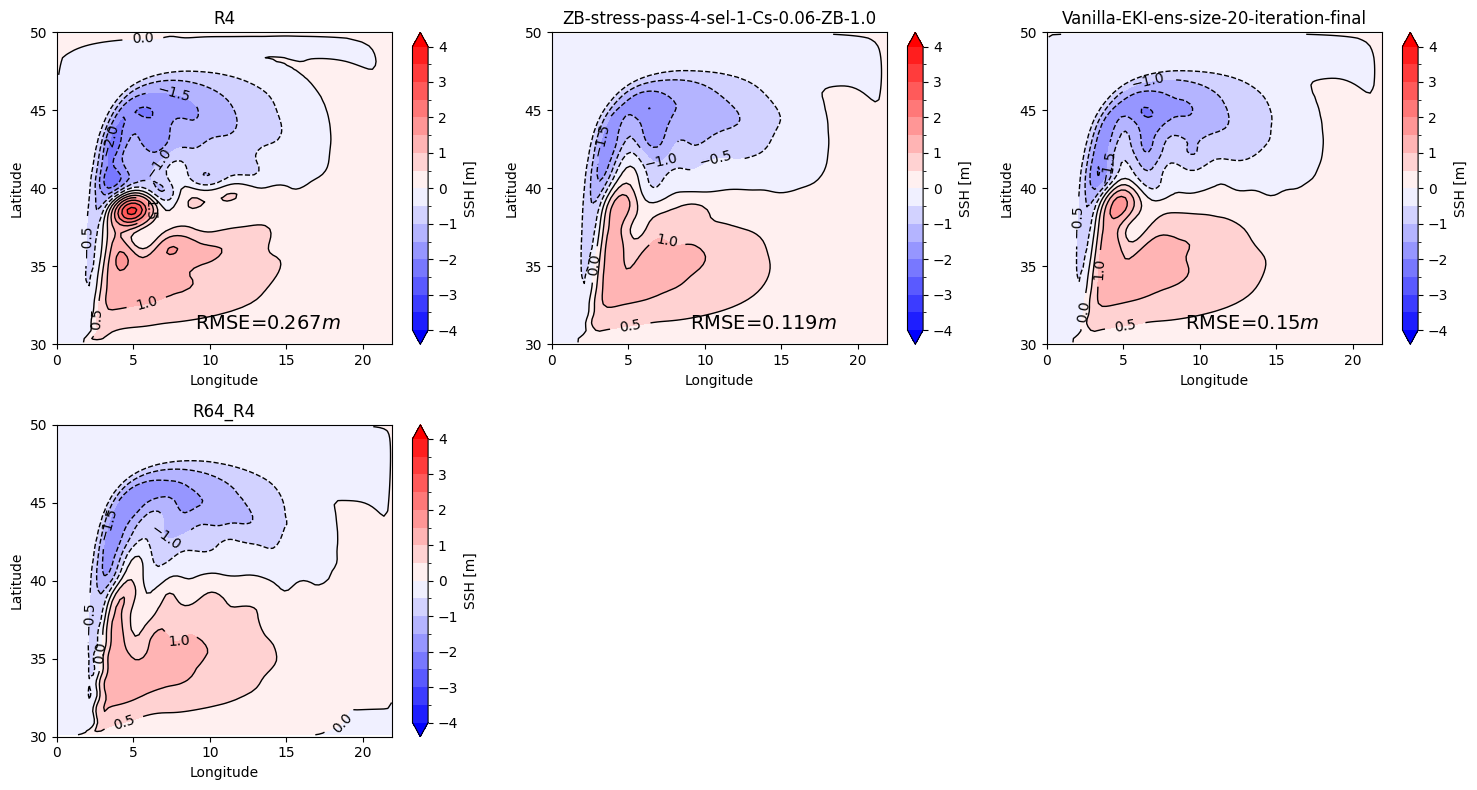

In [65]:
ds.plot_ssh(['R4', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0', 'Vanilla-EKI-ens-size-20-iteration-final', 'R64_R4'])

# Compute error covariance matrix from internal variability of coarse and high-resolution models

In [99]:
Noise_variance = (ds['R4_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].isel(zi=0).var('Time') + \
                 ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].isel(zi=0).var('Time')).compute()

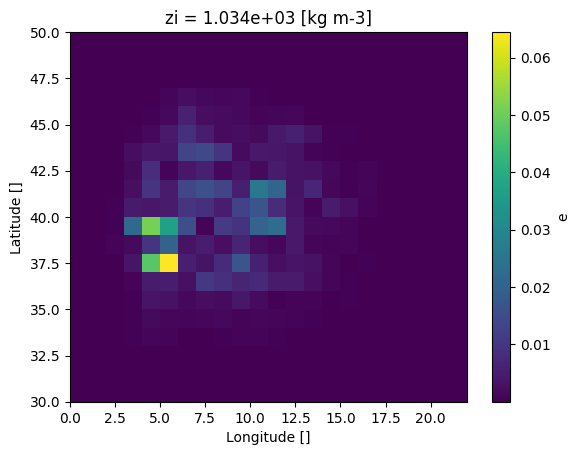

In [104]:
Noise_variance.plot()

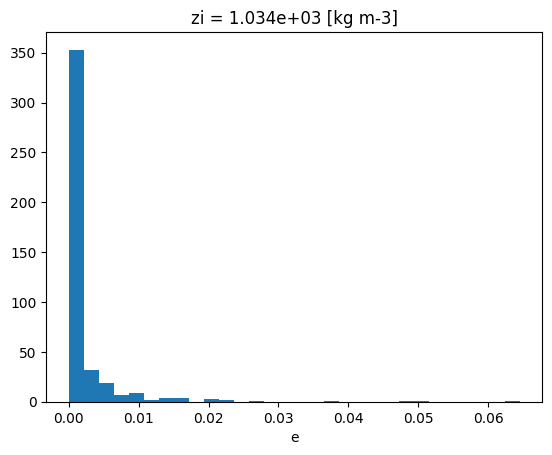

In [111]:
# For the first iteration, we do not want to provide a very accurate noise covariance matrix. Mostly because this would change the optimization objective which is different from our target (RMSE).
# We use noise variance 0.01 which holds most of the support of the variance distribution.
Noise_variance.plot.hist(bins=30);

# Justification of choosing time-averaging interval

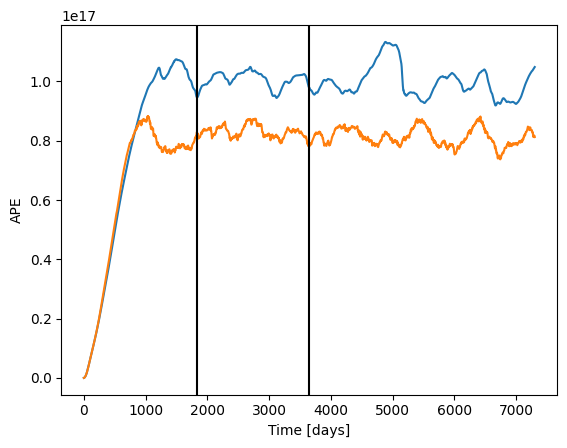

In [130]:
ds['R4'].series.APE.sum('Interface').plot()
ds['R64'].series.APE.sum('Interface').plot()
plt.axvline(x=365*5, color='k')
plt.axvline(x=365*10, color='k')

In [137]:
np.isnan(ds['R4'].ea[-1][0].coarsen({'xh':4, 'yh':4}).mean()).sum().compute()

<xarray.DataArray 'e' ()> Size: 8B
array(0)
Coordinates:
    Time     float64 8B 7.275e+03
    zi       float64 8B 1.034e+03

In [62]:
# Role of choosing the target
np.sqrt((((ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1] - ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].mean('Time')).isel(zi=0))**2).mean().compute())

<xarray.DataArray 'e' ()> Size: 4B
array(0.02700522, dtype=float32)
Coordinates:
    Time     float64 8B 2.7e+03
    zi       float64 8B 1.034e+03

# Optimizing variabiltiy
We are interested in three types of metrics:
* Interface STD
* EKE spectrum in two laeyrs
* PDF of velocity

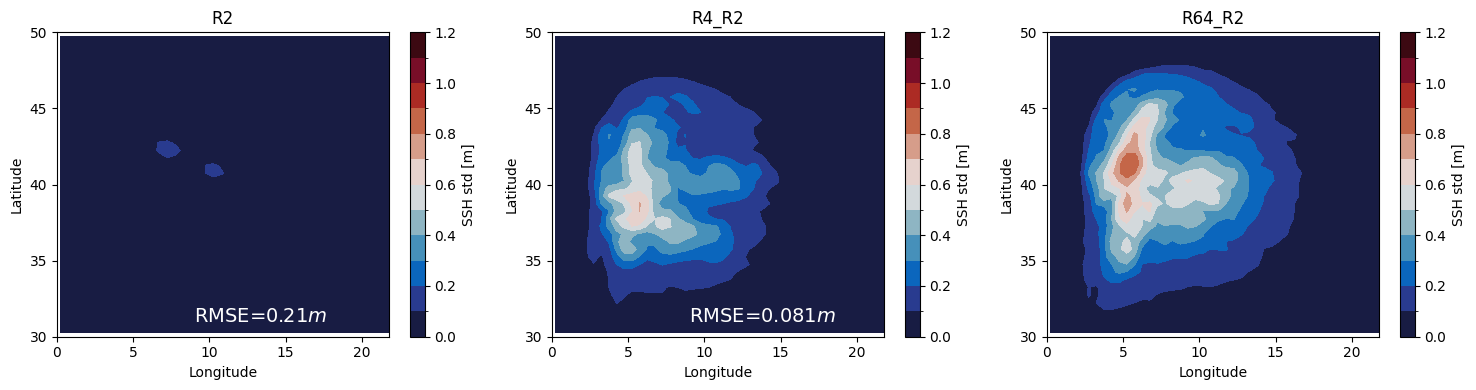

In [8]:
ds.plot_ssh_std(['R2', 'R4_R2', 'R64_R2'])

In [10]:
# Note. It might be better to compute SSH STD on the 1/2-degree grid, but coarsen it to 1 degree grid for simpler solving of inverse problem.

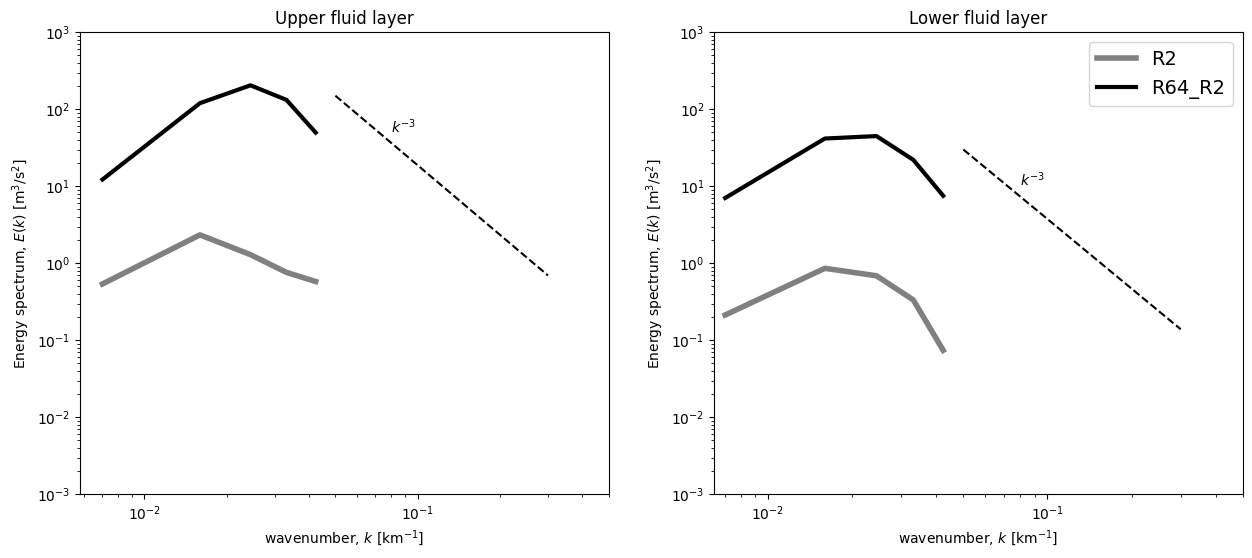

In [24]:
ds.plot_KE_spectrum(['R2', 'R64_R2'])

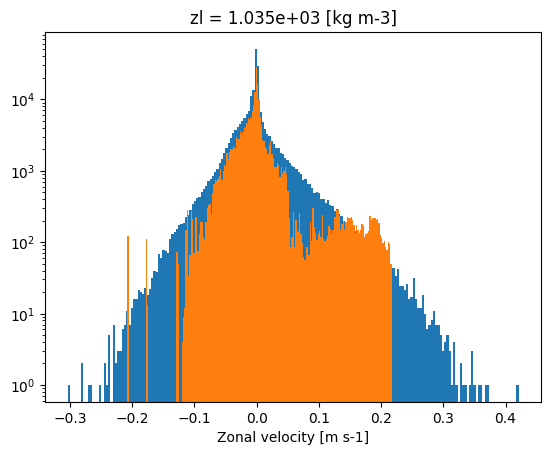

In [45]:
ds['R64_R2'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R2'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
plt.yscale('log')

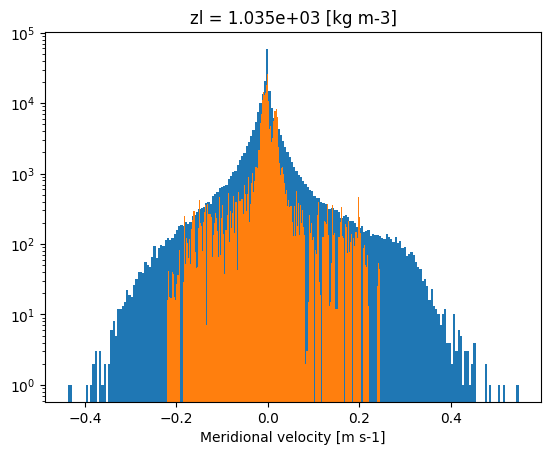

In [46]:
ds['R64_R2'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R2'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
plt.yscale('log')

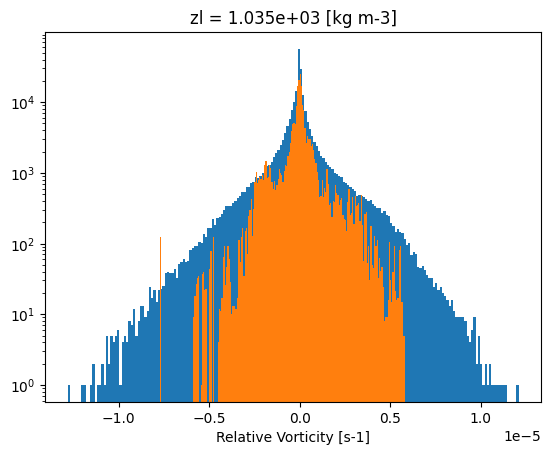

In [47]:
ds['R64_R2'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R2'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
plt.yscale('log')

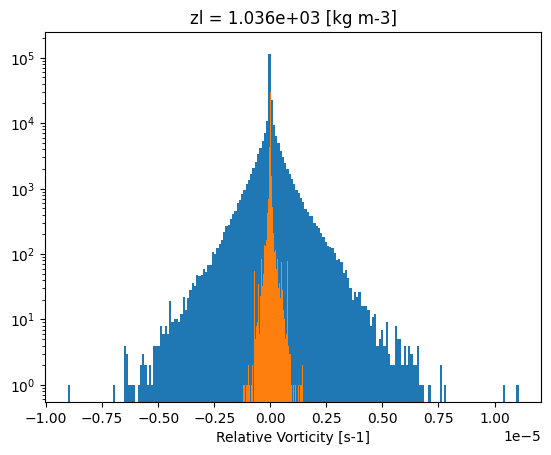

In [48]:
ds['R64_R2'].RV.sel(Time=slice(365*10,None)).isel(zl=1).plot.hist(bins=200);
ds['R2'].RV.sel(Time=slice(365*10,None)).isel(zl=1).plot.hist(bins=200);
plt.yscale('log')

## PDFs already at 1/4 resolution are pretty accurate. And so, using them for optimization might be tricky.

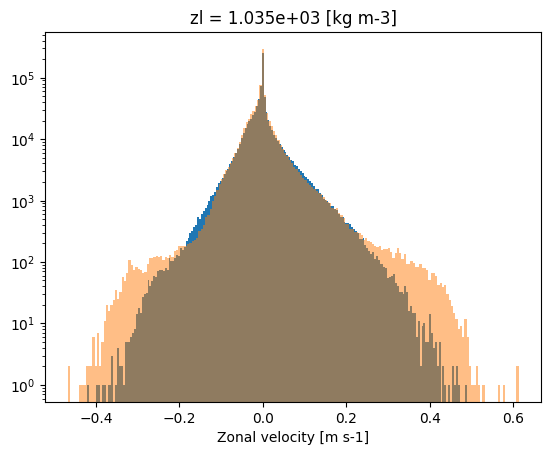

In [51]:
ds['R64_R4'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R4'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200, alpha=0.5);
plt.yscale('log')

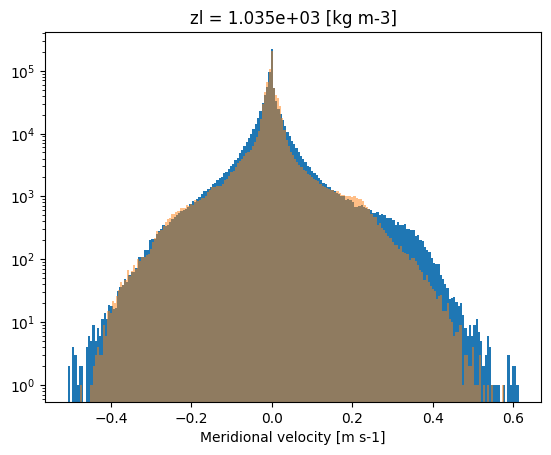

In [52]:
ds['R64_R4'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R4'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200, alpha=0.5);
plt.yscale('log')

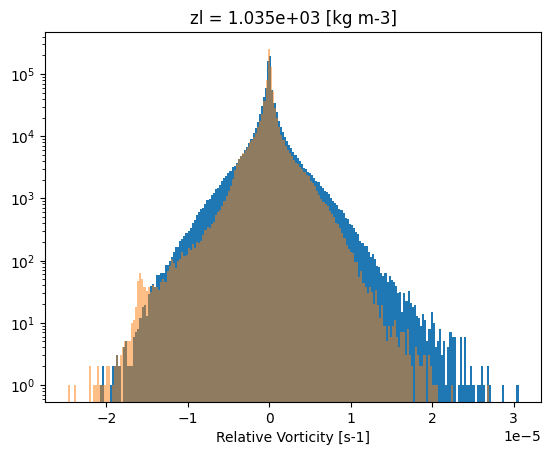

In [53]:
# PDFs 
ds['R64_R4'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R4'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200, alpha=0.5);
plt.yscale('log')

# Check metrics function

In [6]:
import sys
sys.path.append('../scripts')
from loss_DG import variability_metrics

In [19]:
R2 = variability_metrics(ds['R2'].e, ds['R2'].u, ds['R2'].v, ds['R2'].param, coarse_factor=4, compute_e=True)

In [16]:
R4 = variability_metrics(ds['R4'].e, ds['R4'].u, ds['R4'].v, ds['R4'].param, coarse_factor=8, compute_e=True)

In [170]:
R64 = variability_metrics(ds['R64_R2'].e, ds['R64_R2'].u, ds['R64_R2'].v, ds['R64_R2'].param, coarse_factor=4, compute_e=True)

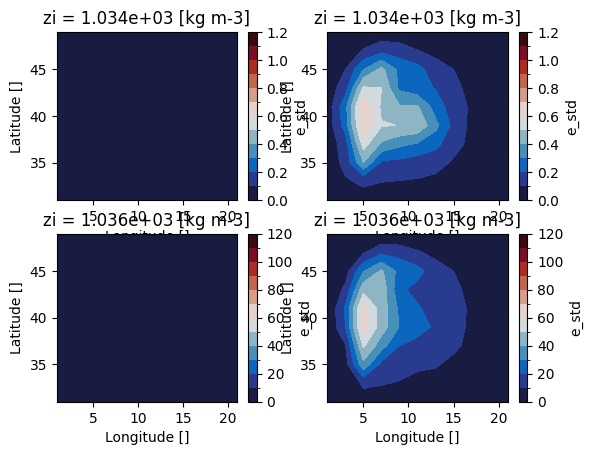

In [144]:
plt.subplot(2,2,1)
R2['e_std'][0].plot.contourf(levels=np.arange(0,1.3,0.1), cmap=cmocean.cm.balance)

plt.subplot(2,2,2)
R64['e_std'][0].plot.contourf(levels=np.arange(0,1.3,0.1), cmap=cmocean.cm.balance)

plt.subplot(2,2,3)
R2['e_std'][1].plot.contourf(levels=np.arange(0,130,10), cmap=cmocean.cm.balance)

plt.subplot(2,2,4)
R64['e_std'][1].plot.contourf(levels=np.arange(0,130,10), cmap=cmocean.cm.balance)

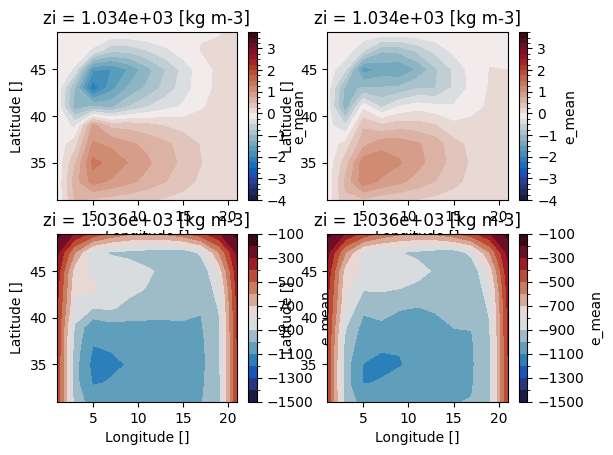

In [171]:
plt.subplot(2,2,1)
R2['e_mean'][0].plot.contourf(levels=np.arange(-4,4,0.25), cmap=cmocean.cm.balance)

plt.subplot(2,2,2)
R64['e_mean'][0].plot.contourf(levels=np.arange(-4,4,0.25), cmap=cmocean.cm.balance)

plt.subplot(2,2,3)
R2['e_mean'][1].plot.contourf(levels=np.arange(-1500,0,100), cmap=cmocean.cm.balance)

plt.subplot(2,2,4)
R64['e_mean'][1].plot.contourf(levels=np.arange(-1500,0,100), cmap=cmocean.cm.balance)

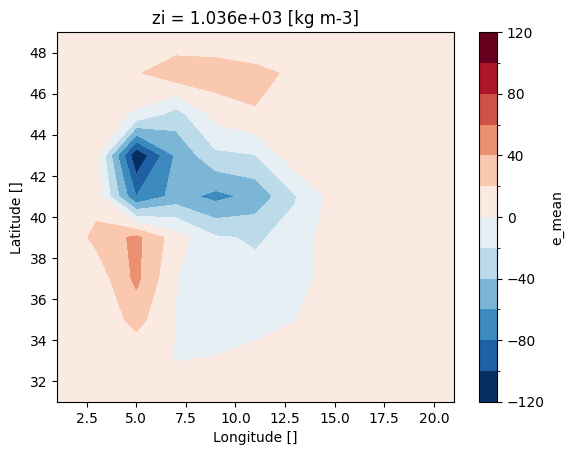

In [172]:
(R64['e_mean'][1] - R2['e_mean'][1]).plot.contourf(levels=15)

(6.418853424874073e-06, 0.0005)

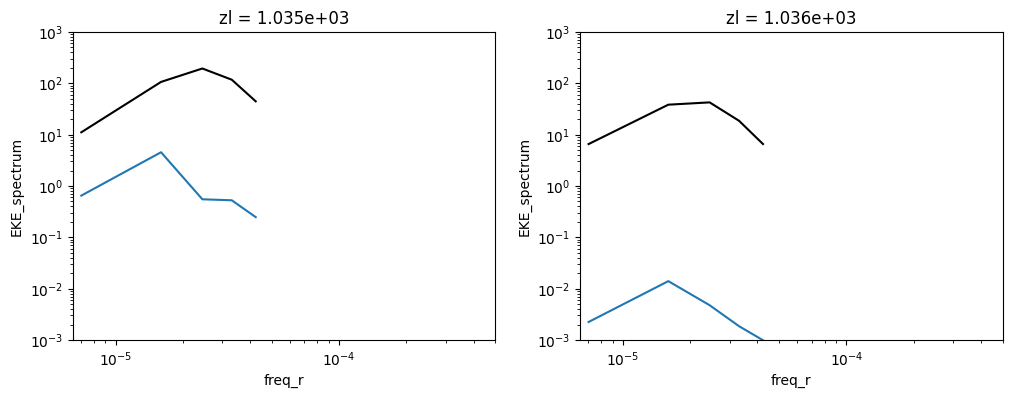

In [173]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
R2['EKE_spectrum'][0].plot()
R64['EKE_spectrum'][0].plot(color='k')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e+3])
plt.xlim([None,0.5e-3])

plt.subplot(1,2,2)
R2['EKE_spectrum'][1].plot()
R64['EKE_spectrum'][1].plot(color='k')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e+3])
plt.xlim([None,0.5e-3])

# Observation error

In [7]:
R64_0 = variability_metrics(ds['R64_R4'].e, ds['R64_R4'].u, ds['R64_R4'].v, ds['R64_R4'].param, Time=slice(1825,3650), coarse_factor=8, compute_e=True)
R64_1 = variability_metrics(ds['R64_R4'].e, ds['R64_R4'].u, ds['R64_R4'].v, ds['R64_R4'].param, Time=slice(3650,5475), coarse_factor=8, compute_e=True)
R64_2 = variability_metrics(ds['R64_R4'].e, ds['R64_R4'].u, ds['R64_R4'].v, ds['R64_R4'].param, Time=slice(5475,7300), coarse_factor=8, compute_e=True)

In [8]:
e_std_var = xr.concat([R64_0['e_std'], R64_1['e_std'], R64_2['e_std']], dim='segment').var('segment')
e_mean_var = xr.concat([R64_0['e_mean'], R64_1['e_mean'], R64_2['e_mean']], dim='segment').var('segment')
EKE_spectrum_var = xr.concat([R64_0['EKE_spectrum'],R64_1['EKE_spectrum'], R64_2['EKE_spectrum']], dim='segment').var('segment')

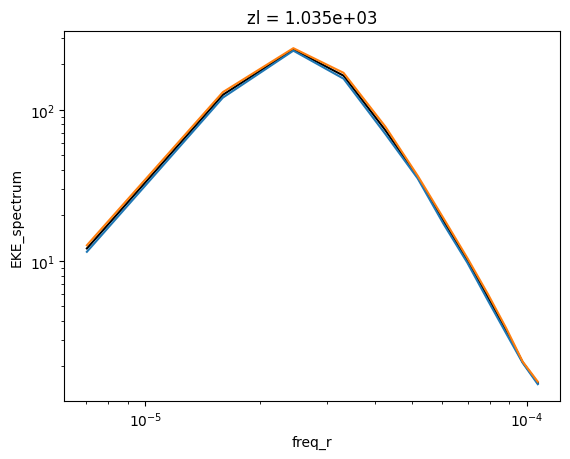

In [9]:
R64_0['EKE_spectrum'][0].plot(color='k')
(R64_0['EKE_spectrum'][0] - np.sqrt(EKE_spectrum_var[0])).plot()
(R64_0['EKE_spectrum'][0] + np.sqrt(EKE_spectrum_var[0])).plot()
plt.yscale('log')
plt.xscale('log')

In [10]:
EKE_spectrum_var[0]

<xarray.DataArray 'EKE_spectrum' (freq_r: 12)> Size: 96B
array([3.64186412e-01, 2.78431081e+01, 2.25696980e+01, 5.60136192e+01,
       1.71207061e+01, 5.44476758e-01, 6.14733722e-01, 1.32416508e-01,
       8.02207083e-02, 1.92415185e-02, 4.19133502e-04, 8.62407168e-04])
Coordinates:
    zl       float64 8B 1.035e+03
  * freq_r   (freq_r) float64 96B 7.022e-06 1.597e-05 ... 9.768e-05 0.000107

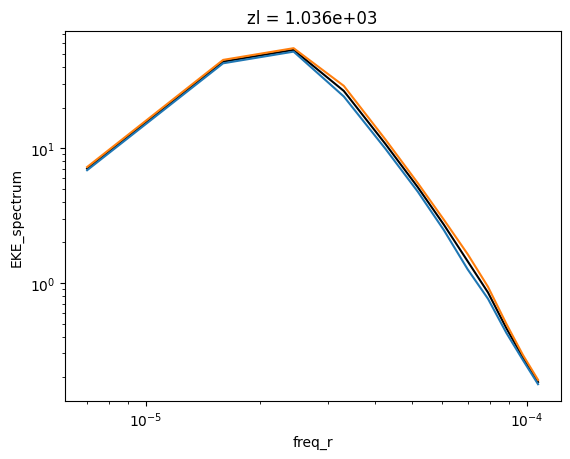

In [11]:
R64_0['EKE_spectrum'][1].plot(color='k')
(R64_0['EKE_spectrum'][1] - np.sqrt(EKE_spectrum_var[1])).plot()
(R64_0['EKE_spectrum'][1] + np.sqrt(EKE_spectrum_var[1])).plot()
plt.yscale('log')
plt.xscale('log')

In [12]:
EKE_spectrum_var[1]

<xarray.DataArray 'EKE_spectrum' (freq_r: 12)> Size: 96B
array([3.72688563e-02, 1.62488154e+00, 2.50988701e+00, 5.81510480e+00,
       7.17093350e-01, 1.41441443e-01, 5.75372964e-02, 3.50509321e-02,
       7.53298397e-03, 1.27502840e-03, 1.50450719e-04, 4.60086670e-05])
Coordinates:
    zl       float64 8B 1.036e+03
  * freq_r   (freq_r) float64 96B 7.022e-06 1.597e-05 ... 9.768e-05 0.000107

In [13]:
R64_dataset = xr.Dataset()
R64_dataset['e_std'] = R64_0['e_std']
R64_dataset['EKE_spectrum'] = R64_0['EKE_spectrum']
R64_dataset['e_mean'] = R64_0['e_mean']
R64_dataset['e_std_var'] = e_std_var
R64_dataset['e_mean_var'] = e_mean_var
R64_dataset['EKE_spectrum_var'] = EKE_spectrum_var

R64_dataset['e_std_var_ave'] = e_std_var*0 + e_std_var.mean(['xh', 'yh'])
R64_dataset['e_mean_var_ave'] = e_mean_var*0 + e_mean_var.mean(['xh', 'yh'])
R64_dataset['EKE_spectrum_var_ave'] = EKE_spectrum_var*0 + EKE_spectrum_var.mean(['freq_r'])

In [14]:
R64_dataset.astype('float32').to_netcdf('../scripts/R64_R4/full.nc')

In [15]:
R64_dataset = xr.open_dataset('../scripts/R64_R4/full.nc')

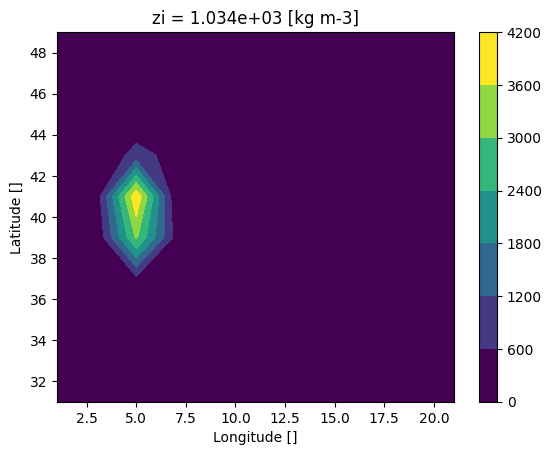

In [37]:
((R4['e_mean'] - R64_dataset['e_mean'])**2 / R64_dataset['e_mean_var_ave'])[0].plot.contourf(levels=8)

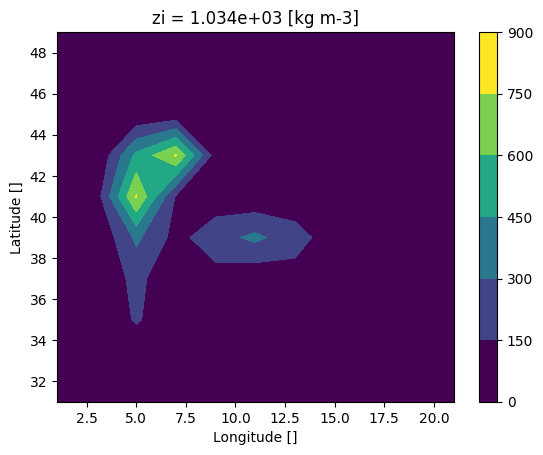

In [36]:
((R4['e_std'] - R64_dataset['e_std'])**2 / R64_dataset['e_std_var_ave'])[0].plot.contourf(levels=8)

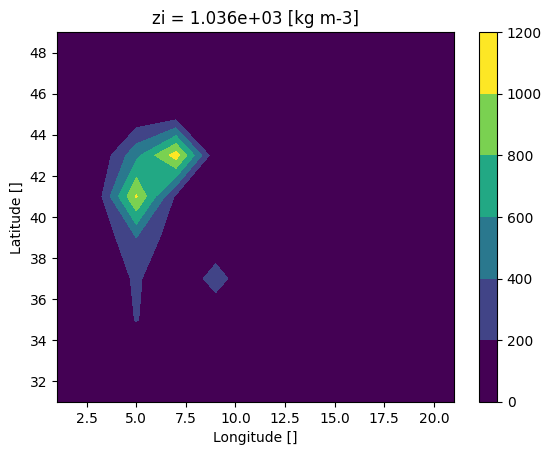

In [35]:
((R4['e_std'] - R64_dataset['e_std'])**2 / R64_dataset['e_std_var_ave'])[1].plot.contourf(levels=8)

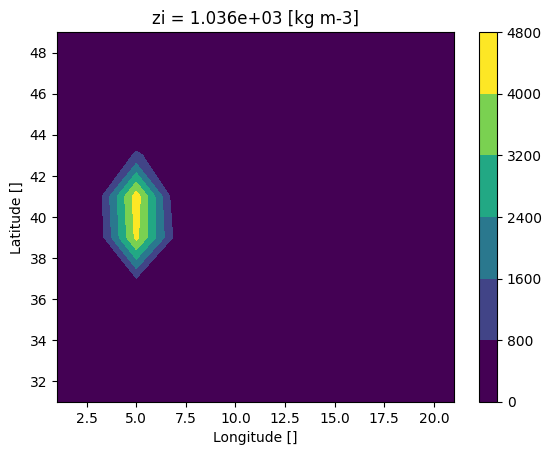

In [34]:
((R4['e_mean'] - R64_dataset['e_mean'])**2 / R64_dataset['e_mean_var_ave'])[1].plot.contourf(levels=8)

In [21]:
R64_dataset.e_std_var[0].values.mean()

0.00014022918

# Analysis of the parameter's convergence

In [184]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')

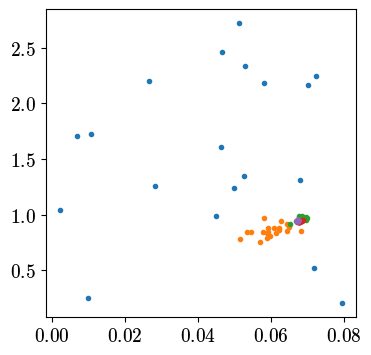

In [185]:
for iter in range(5):
    plt.plot(metrics.Cs[iter], metrics.ZB[iter], '.')

In [186]:
rmse_train = np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh']))
rmse_mean_train = np.sqrt(((metrics.ssh_coarse.mean('ens') - metrics.ssh_fine)**2).mean(['yh', 'xh'])) # Metric used by Dunbar
rmse_mean_test = np.sqrt(((metrics.ssh_coarse.mean('ens') - ds['R64_R1'].ssh_mean)**2).mean(['yh', 'xh']))

Text(0.5, 1.0, '')

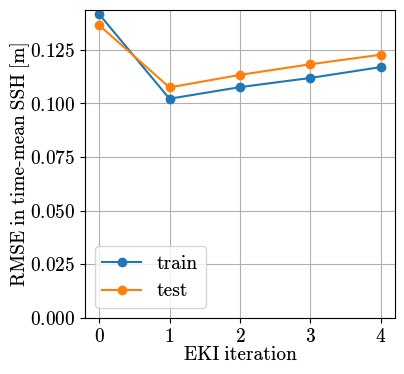

In [187]:
rmse_mean_train.plot(marker='o', label='train')
rmse_mean_test.plot(marker='o', label='test')
plt.legend()
plt.ylim([0,None])
plt.grid()
plt.ylabel('RMSE in time-mean SSH [m]')
plt.xlabel('EKI iteration')
plt.xticks(np.arange(0,5));
plt.title('')

# Animation of particles on the loss landscape

In [5]:
from helpers.computational_tools import Lk_error
def error_ssh(exp):
    return Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]

In [6]:
from functools import cache
@cache
def error_2d(error_function = error_ssh, prefix='ZB-clean'):
    ZBs = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-Cs-0.03' in exp])
    Css = sorted(set([float(exp.split('-')[-3]) for exp in ds.exps if f'{prefix}-Cs-' in exp]))
    
    error = np.zeros((len(ZBs), len(Css)))
    for i, Cs in enumerate(Css):
        for j, ZB in enumerate(ZBs):
            try:
                error[j,i] = error_function(f'{prefix}-Cs-{Cs:.2f}-ZB-{ZB}')
            except:
                error[j,i] = np.nan
    error = xr.DataArray(error, dims=['ZB', 'Cs'], coords={'Cs': Css, 'ZB': ZBs})
    return error

In [7]:
error_ssh('ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0')

0.118933715

In [8]:
ssh = {'v0': 0.26709399, 'vmin': 0.0, 'error_function': error_ssh, 
           'cbar_ticks': np.arange(0.0,0.7,0.05), 
           'cbar_extend': 'neither', 'cbar_label': 'RMSE in \ntime-mean SSH, $\mathrm{m}$'};

In [9]:
def plot_panels(exps, labels, v0, vmin, error_function, color='w', cbar_ticks=None, cbar_extend='none', cbar_label=''):
    vmin=0.00; vmax=0.3

    for col in range(len(exps)):
        label=labels[col]
        exp=exps[col]
        e = error_2d(error_function = error_function, prefix=exp)
        X,Y = np.meshgrid(e.Cs, e.ZB)
        em = np.ma.masked_invalid(e)
        im = plt.pcolor(X,Y,em,vmin=vmin,vmax=vmax,cmap='RdBu_r')
        # https://stackoverflow.com/questions/35905393/python-leave-numpy-nan-values-from-matplotlib-heatmap-and-its-legend
        plt.gca().patch.set(hatch='OO', edgecolor='black')
        
        cb = plt.colorbar(im, fraction=0.3, pad=0.05, aspect=15, ticks=cbar_ticks, extend=cbar_extend)
        cb.set_label('RMSE [m]', fontsize=16, labelpad=10)
        if col<len(exps)-1:
            cb.ax.set_yticklabels(['']*len(cbar_ticks))
            cb.set_label('')
        
        plt.xticks(e.Cs.values, rotation=60)
        if len(e.ZB) > 16:
            plt.yticks(e.ZB.values[::2])
        else:
            plt.yticks(e.ZB.values)
            
        plt.xlabel('')
        if col==0:
            plt.ylabel('ZB scaling coefficient, $\gamma$', fontsize=20)
        else:
            plt.ylabel('')
        plt.title('ZB20-Smooth')
        plt.xlabel('Smagorinsky coefficient $C_S$', ha='center', fontsize=16)
    

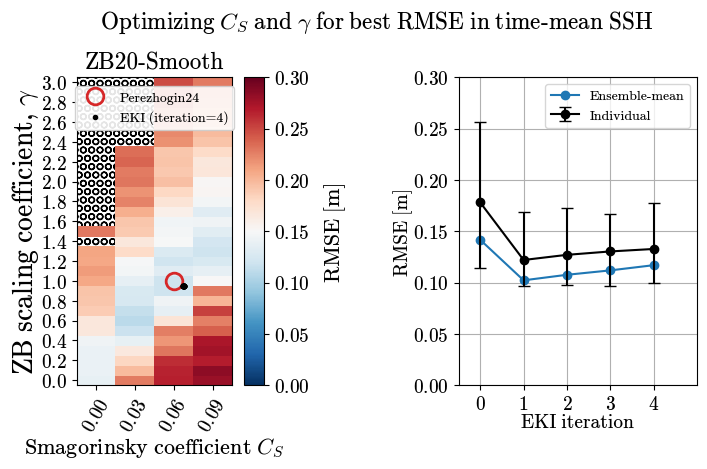

In [11]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')
def plot(iteration=0, metrics=metrics):
    default_rcParams({'axes.formatter.limits': (-3,3), 'figure.subplot.wspace': 0.6})
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plot_panels(['ZB-stress-pass-4-sel-1'], ['ZB20-Smooth'], **ssh)
    plt.plot(0.06,1.0,color='tab:red', marker='o', markerfacecolor='none', markeredgewidth=2, markersize=12, label='Perezhogin24', ls='')

    plt.plot(metrics.Cs[iteration], metrics.ZB[iteration], '.', color='k', label=f'EKI (iteration={iteration})')
    plt.legend(bbox_to_anchor=(0.5,0.9), loc='center', framealpha=0.9, fontsize=10)

    plt.subplot(1,2,2)
    rmse_train = np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh']))
    rmse_mean_train = np.sqrt(((metrics.ssh_coarse.mean('ens') - metrics.ssh_fine)**2).mean(['yh', 'xh'])) # Metric used by Dunbar
    plt.plot(np.arange(iteration+1), rmse_mean_train[:iteration+1], marker='o', label='Ensemble-mean')
    #plt.plot(np.arange(iteration+1), rmse_mean_test[:iteration+1], marker='o', label='Ensemble-mean (10y)')
    plt.title('')
    plt.ylabel('RMSE [m]')
    plt.ylim([0.00,0.3])
    plt.xticks(np.arange(5))
    plt.xlim([-0.5,5])
    plt.grid()
    plt.xlabel('EKI iteration')
    ymin = rmse_train.min('ens')[:iteration+1]
    ymax = rmse_train.max('ens')[:iteration+1]
    ymid = rmse_train.mean('ens')[:iteration+1]

    yerr = np.vstack([ymid - ymin, ymax - ymid])
    plt.errorbar(np.arange(iteration+1), ymid, yerr=yerr, fmt='o', capsize=4, color='k', label='Individual', ls='-')
    plt.legend(fontsize=10)
    
    plt.suptitle('Optimizing $C_S$ and $\gamma$ for best RMSE in time-mean SSH', y=1.05)
plot(4)

In [317]:
create_animation_ffmpeg(plot, np.arange(5), filename='Double-Gyre-EKI.mp4', FPS=1)

Frames already exists in folder .ffmpeg/Double-Gyre-EKI


Do you want to update snapshots?: [y/n] y


Savefig .ffmpeg/Double-Gyre-EKI/frame-0.png
Savefig .ffmpeg/Double-Gyre-EKI/frame-1.png86
Savefig .ffmpeg/Double-Gyre-EKI/frame-2.png4
Savefig .ffmpeg/Double-Gyre-EKI/frame-3.png86
Savefig .ffmpeg/Double-Gyre-EKI/frame-4.png74
Native resolution of snapshots is used: 1406x934

Animation Double-Gyre-EKI.mp4 at FPS=1 will last for 5.0 seconds. The frames are saved to 
.ffmpeg/Double-Gyre-EKI

Running the command:
cd /home/pp2681/calibration/notebooks; ffmpeg -y -framerate 1 -i .ffmpeg/Double-Gyre-EKI/frame-%d.png -s:v 1406x934 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p Double-Gyre-EKI.mp4


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Sensitivity to EKI algorithms

Text(0.5, 1.05, 'Vanilla EKI')

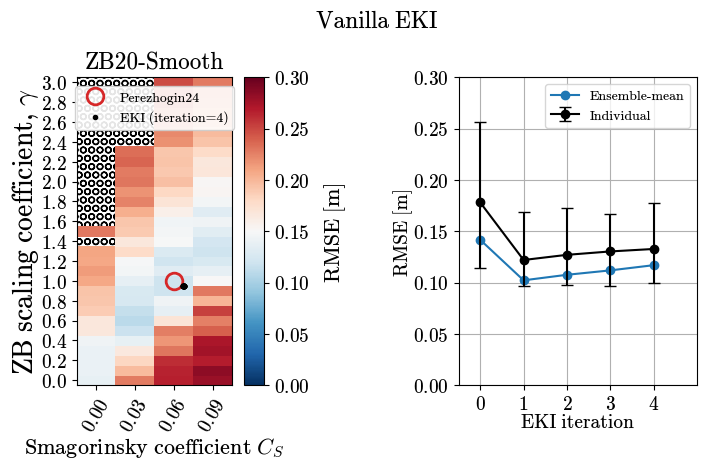

In [25]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Vanilla EKI", y=1.05)

Text(0.5, 1.05, 'Vanilla EKI different seed')

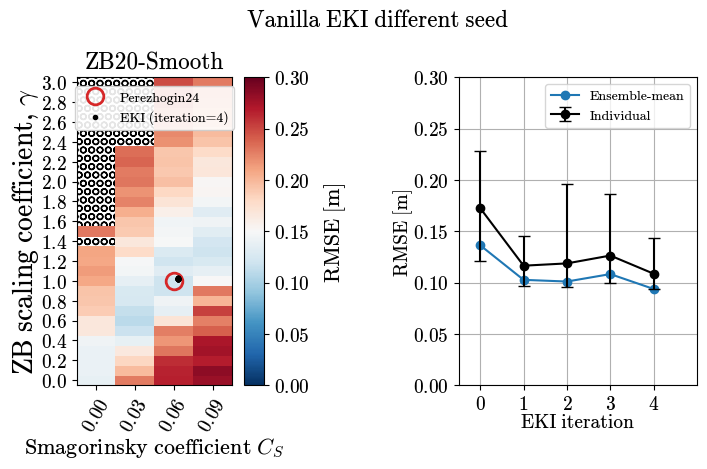

In [24]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20-seed/metrics.nc')
plot(4,metrics)
plt.suptitle("Vanilla EKI different seed", y=1.05)

Text(0.5, 1.05, 'Vanilla EKI bigger ensemble')

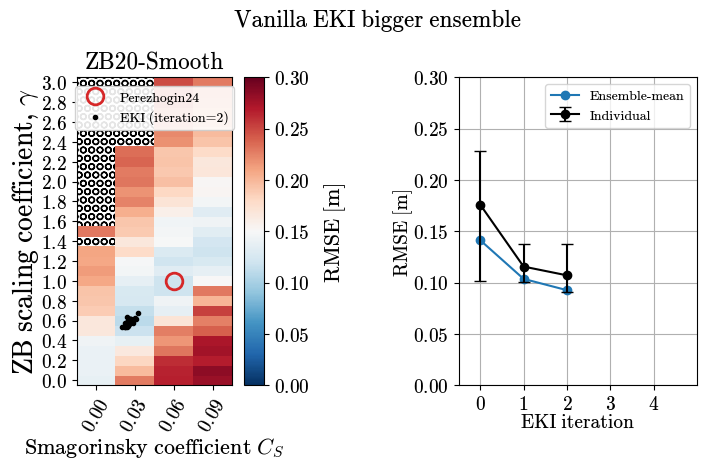

In [31]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-40/metrics.nc')
plot(2,metrics)
plt.suptitle("Vanilla EKI bigger ensemble", y=1.05)

Text(0.5, 1.05, 'SECNice EKI')

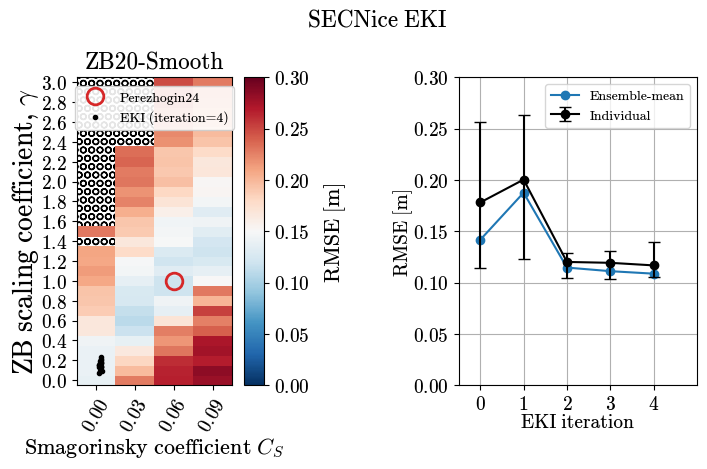

In [38]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/SECNice-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("SECNice EKI", y=1.05)

Text(0.5, 1.05, 'Data-Misfit-Controller EKI')

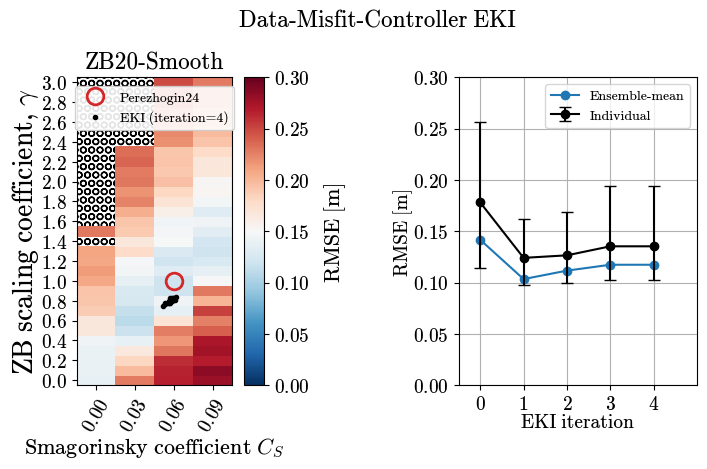

In [44]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/MFC-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Data-Misfit-Controller EKI", y=1.05)

Text(0.5, 1.05, 'Data-Misfit-Controller+SECNice+Nesterov EKI')

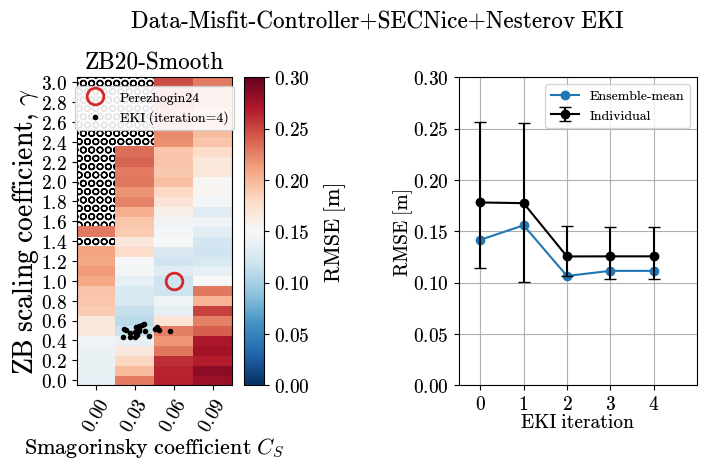

In [49]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/ALL-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Data-Misfit-Controller+SECNice+Nesterov EKI", y=1.05)

Text(0.5, 1.05, 'Randomized-Likelihood EKI')

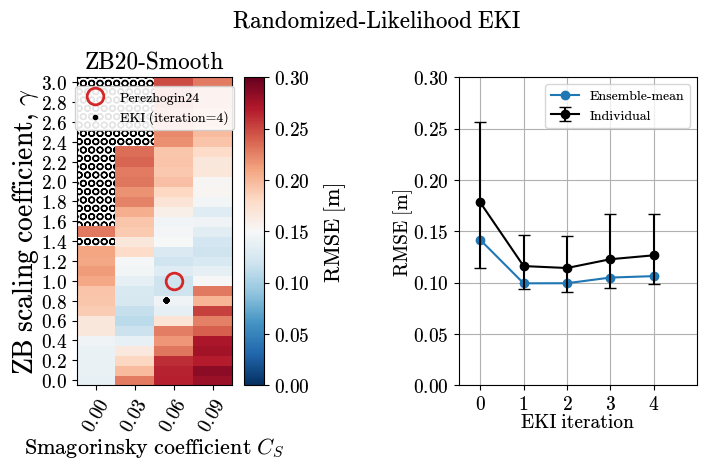

In [54]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/RL-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Randomized-Likelihood EKI", y=1.05)

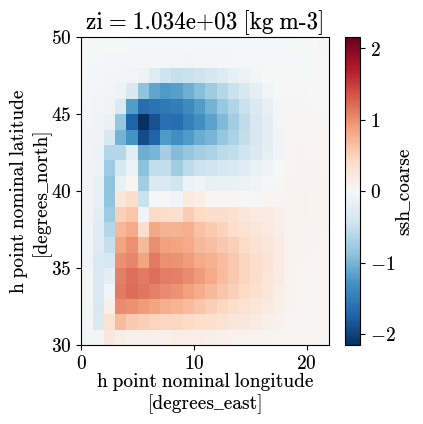

In [79]:
metrics.ssh_coarse[0][8].plot()

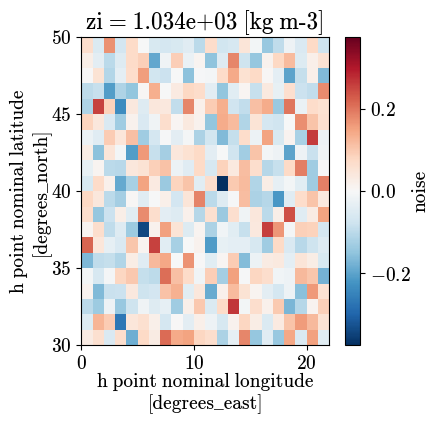

In [65]:
metrics.noise[8].plot()

# Emulate stage

In [12]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# X: (100, 2) input points
# Ys: (100, 440) output values for each GP
X = np.stack([metrics.Cs.stack(z=('iter','ens')), metrics.ZB.stack(z=('iter','ens'))],-1)
Ys = metrics.ssh_coarse.stack(z=('iter','ens')).stack(t=['yh', 'xh']).values

# Remove exploded experiments
X = np.delete(X, 18, axis=0)
Ys = np.delete(Ys, 18, axis=0)

# Train GPs to predict each spatial grid point
gps = []
for i in range(440):
    #print(f'{i} spatial coordinate')
    y = Ys[:, i]
    kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) \
           + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-3, 1e1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
    gp.fit(X, y)
    gps.append(gp)

In [15]:
# Train GP to predict RMSE only
Y_mse = np.mean((Ys - metrics.ssh_fine.stack(t=['yh', 'xh']).values)**2, -1)
kernel = C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) \
           + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-5, 1e5))
gp_mse = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp_mse.fit(X, Y_mse)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=5, normalize_y=True)

# Compute Likelihood as a function of inputs

In [16]:
def likelihood(Cs, ZB, gps, gp_mse, yobs):
    '''
    Cs and ZB are 1d arrays or scalars
    '''
    _X, _Y = np.meshgrid(Cs, ZB)
    X_test = np.stack([_X.ravel(), _Y.ravel()],-1)

    Y_mean = []
    Y_std = []
    for gp in gps:
        y_mean, y_std = gp.predict(X_test, return_std=True)
        Y_mean.append(y_mean)
        Y_std.append(y_std)
    
    Y_mean = np.stack(Y_mean, axis=1)
    Y_std = np.stack(Y_std, axis=1)

    logLK =  - 0.5 * (((Y_mean - yobs)**2) / (Y_std**2)).sum(-1) - \
               0.5 * np.sum(np.log(2 * np.pi * (Y_std**2)), -1)
            
    LK = np.exp(logLK)

    RMSE = np.sqrt(np.mean((Y_mean - yobs)**2, -1))
    
    RMSE_stupid = np.sqrt(gp_mse.predict(X_test, return_std=False))
    
    return _X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid

Text(0.5, 1.0, 'Emulator std')

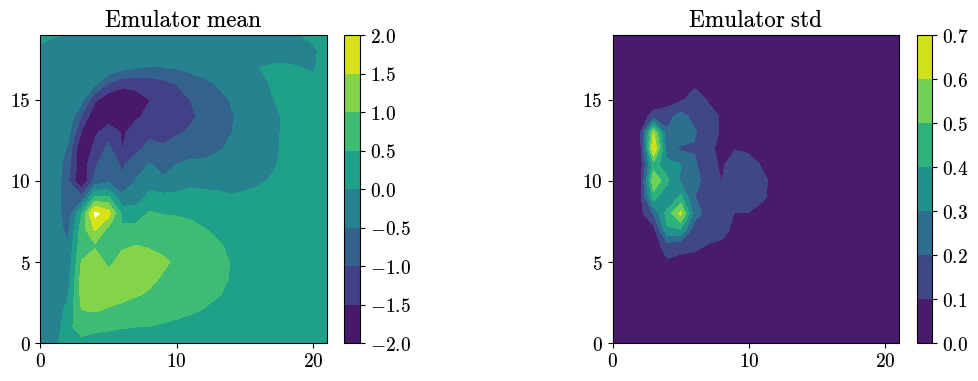

In [17]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.06],[0.0],gps,gp_mse,metrics.ssh_fine.values.ravel())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(Y_mean.reshape([20,22]), levels=np.arange(-2,2.5,0.5))
plt.colorbar()
plt.title('Emulator mean')

plt.subplot(1,2,2)
plt.contourf(Y_std.reshape([20,22]))
plt.colorbar()
plt.title('Emulator std')

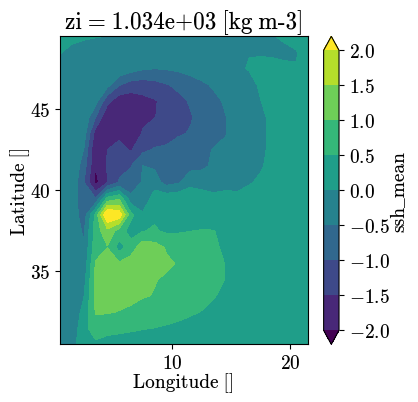

In [134]:
ds['R4_R1'].ssh_mean.plot.contourf(vmin=-2, vmax=1.6, cmap='viridis', levels=np.arange(-2,2.5,0.5))
#ds['ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R1'].ssh_mean.plot.contourf(vmin=-2, vmax=1.6, cmap='viridis', levels=np.arange(-2,2.5,0.5))

In [19]:
# im = plt.contourf(_X,_Y,logLK.reshape(100,100))
# plt.colorbar(im)

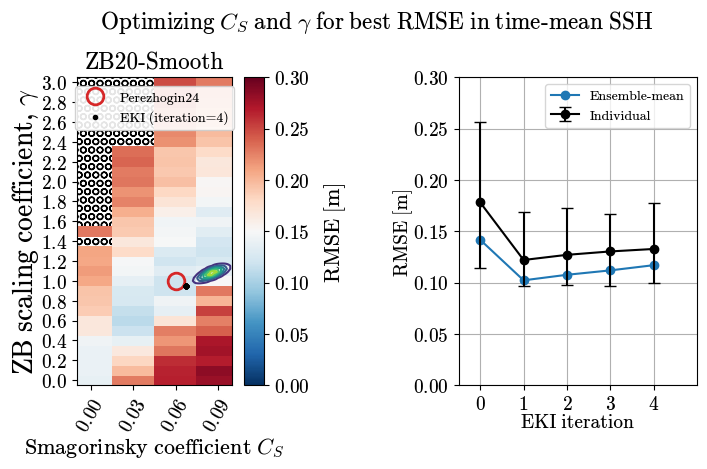

In [202]:
def plot(iteration=0):
    default_rcParams({'axes.formatter.limits': (-3,3), 'figure.subplot.wspace': 0.6})
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plot_panels(['ZB-stress-pass-4-sel-1'], ['ZB20-Smooth'], **ssh)
    plt.plot(0.06,1.0,color='tab:red', marker='o', markerfacecolor='none', markeredgewidth=2, markersize=12, label='Perezhogin24', ls='')

    plt.plot(metrics.Cs[iteration], metrics.ZB[iteration], '.', color='k', label=f'EKI (iteration={iteration})')
    plt.contour(_X,_Y,LK.reshape(100,100), label='posterior')
    plt.xlim([-0.01, 0.1])

    plt.legend(bbox_to_anchor=(0.5,0.9), loc='center', framealpha=0.9, fontsize=10)


    plt.subplot(1,2,2)
    plt.plot(np.arange(iteration+1), rmse_mean_train[:iteration+1], marker='o', label='Ensemble-mean')
    #plt.plot(np.arange(iteration+1), rmse_mean_test[:iteration+1], marker='o', label='Ensemble-mean (10y)')
    plt.title('')
    plt.ylabel('RMSE [m]')
    plt.ylim([0.00,0.3])
    plt.xticks(np.arange(5))
    plt.xlim([-0.5,5])
    plt.grid()
    plt.xlabel('EKI iteration')
    ymin = rmse_train.min('ens')[:iteration+1]
    ymax = rmse_train.max('ens')[:iteration+1]
    ymid = rmse_train.mean('ens')[:iteration+1]

    yerr = np.vstack([ymid - ymin, ymax - ymid])
    plt.errorbar(np.arange(iteration+1), ymid, yerr=yerr, fmt='o', capsize=4, color='k', label='Individual', ls='-')
    plt.legend(fontsize=10)
    
    plt.suptitle('Optimizing $C_S$ and $\gamma$ for best RMSE in time-mean SSH', y=1.05)
plot(4)

# Emulate SSH or its MSE (EKI dataset)? 

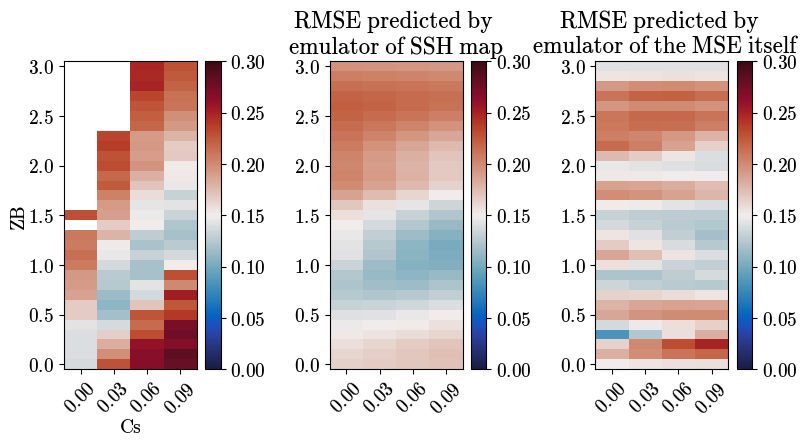

In [29]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.0,0.03,0.06,0.09],np.arange(0.0,3.1,0.1),gps,gp_mse,metrics.ssh_fine.values.ravel())

fig = plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
error_2d(error_ssh, 'ZB-stress-pass-4-sel-1').plot(vmin=0, vmax=0.3, cmap=cmocean.cm.balance)
plt.xticks([0,0.03,0.06,0.09], rotation=45);

plt.subplot(1,3,2)
plt.pcolormesh(_X,_Y,RMSE.reshape(31,4), vmin=0, vmax=0.3, cmap=cmocean.cm.balance)
plt.colorbar()
plt.title('RMSE predicted by \nemulator of SSH map')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

plt.subplot(1,3,3)
plt.pcolormesh(_X,_Y,RMSE_stupid.reshape(31,4), vmin=0, vmax=0.3, cmap=cmocean.cm.balance)
plt.colorbar()
plt.title('RMSE predicted by \n emulator of the MSE itself')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

# Emulate SSH or its MSE (grid-search dataset)?

In [37]:
prefix = 'ZB-stress-pass-4-sel-1'
ZBs = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-Cs-0.03' in exp])
Css = sorted(set([float(exp.split('-')[-3]) for exp in ds.exps if f'{prefix}-Cs-' in exp]))

metrics = xr.Dataset()
metrics['ssh_fine'] = ds['R64'].ssh_mean.coarsen({'xh':64, 'yh':64}).mean().compute()
metrics['ssh_coarse'] = xr.DataArray(np.nan * np.zeros((len(Css), len(ZBs), 20, 22)), dims=['Cs', 'ZB', 'yh', 'xh'], coords={'Cs': Css, 'ZB': ZBs})

for i, Cs in enumerate(Css):
    for j, ZB in enumerate(ZBs):
        try:
            metrics['ssh_coarse'][i,j] = ds[f'{prefix}-Cs-{Cs:.2f}-ZB-{ZB}'].ssh_mean.coarsen({'xh':4, 'yh':4}).mean().compute()
        except:
            pass

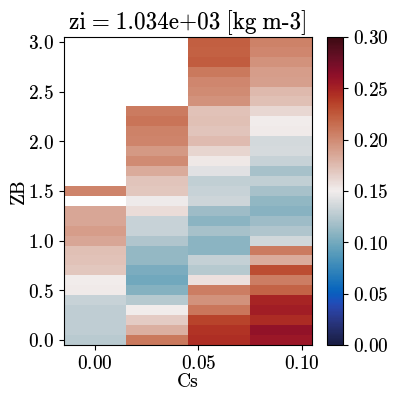

In [48]:
np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh'])).plot(vmin=0, vmax=0.3, cmap=cmocean.cm.balance, x='Cs')

In [229]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern

# X: (124, 2) input points
# Ys: (124, 440) output values for each GP
_X, _Y = np.meshgrid(metrics.Cs, metrics.ZB)
X = np.stack([_X.ravel(), _Y.ravel()],-1)
Ys = metrics.ssh_coarse.stack(z=(['ZB', 'Cs'])).stack(t=['yh', 'xh']).values

# Remove exploded experiments
mask = ~np.any(np.isnan(Ys), axis=1)
X = X[mask]
Ys = Ys[mask]

In [232]:
# Train GPs to predict each spatial grid point
gps = []
for i in range(440):
    #print(f'{i} spatial coordinate')
    y = Ys[:, i]
    kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) \
            + WhiteKernel(noise_level=1e-1) # Typical noise level we know from EKI studies
           #+ WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-3, 1e1))
            
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
    gp.fit(X, y)
    gps.append(gp)

In [233]:
# Train GP to predict MSE directly
Y_mse = np.mean((Ys - metrics.ssh_fine.stack(t=['yh', 'xh']).values)**2, -1)
kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) \
         + WhiteKernel(noise_level=1e-2) # Same noise level as for SSH emulator
         #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+10))
gp_mse = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp_mse.fit(X, Y_mse)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=5, normalize_y=True)

Text(0.5, 1.0, 'Emulator std')

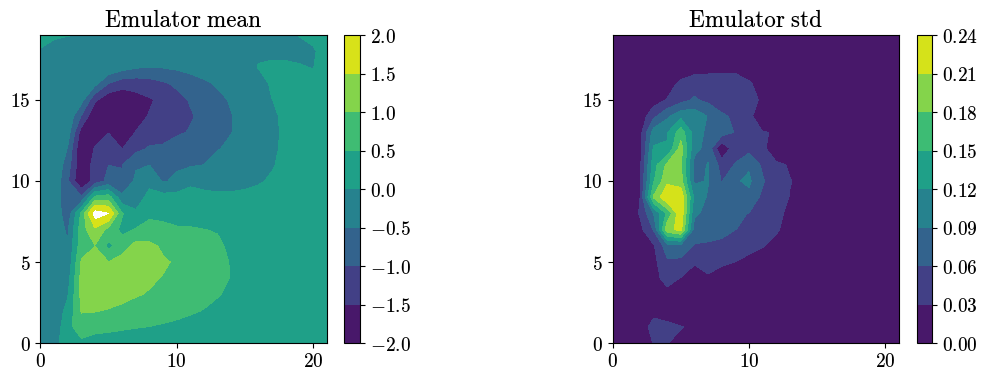

In [234]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.06],[0.0],gps,gp_mse,metrics.ssh_fine.values.ravel())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(Y_mean.reshape([20,22]), levels=np.arange(-2,2.5,0.5))
plt.colorbar()
plt.title('Emulator mean')

plt.subplot(1,2,2)
plt.contourf(Y_std.reshape([20,22]))
plt.colorbar()
plt.title('Emulator std')

In [235]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.0,0.03,0.06,0.09],np.arange(0.0,3.1,0.1),gps,gp_mse,metrics.ssh_fine.values.ravel())

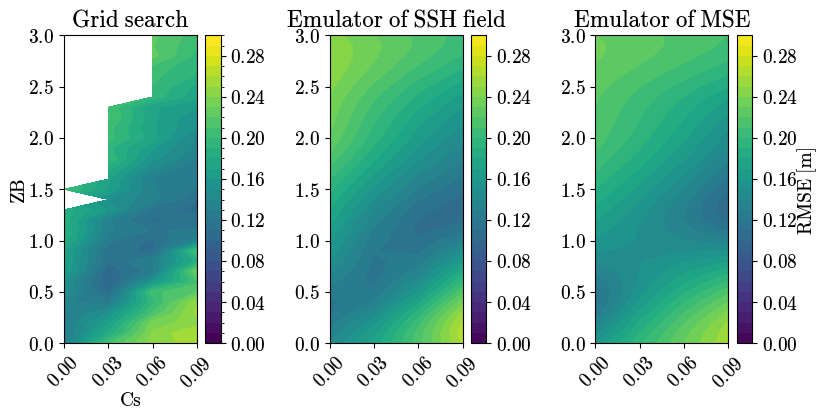

In [236]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.0,0.03,0.06,0.09],np.arange(0.0,3.1,0.1),gps,gp_mse,metrics.ssh_fine.values.ravel())

RMSE_grid = np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh']))

fig = plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
RMSE_grid.plot.contourf(vmin=0, vmax=0.3, cmap='viridis', x='Cs', levels=np.arange(0.0,0.301,0.01))
plt.xticks([0,0.03,0.06,0.09], rotation=45);
plt.title('Grid search')

plt.subplot(1,3,2)
plt.contourf(_X,_Y,RMSE.reshape(31,4), vmin=0, vmax=0.3, cmap='viridis', levels=np.arange(0.0,0.301,0.01))
plt.colorbar()
plt.title('Emulator of SSH field')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

plt.subplot(1,3,3)
plt.contourf(_X,_Y,RMSE_stupid.reshape(31,4), vmin=0, vmax=0.3, cmap='viridis', levels=np.arange(0.0,0.301,0.01))
plt.colorbar(label='RMSE [m]')
plt.title('Emulator of MSE')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

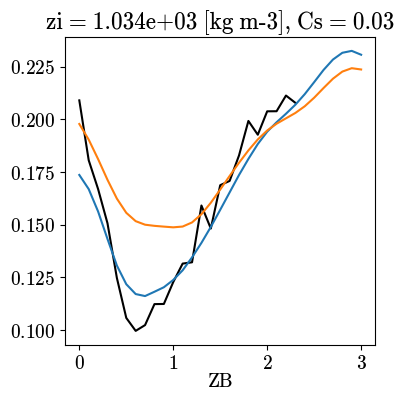

In [237]:
RMSE_grid[1].plot(color='k')
plt.plot(RMSE_grid.ZB, RMSE.reshape(31,4)[:,1])
plt.plot(RMSE_grid.ZB, RMSE_stupid.reshape(31,4)[:,1])

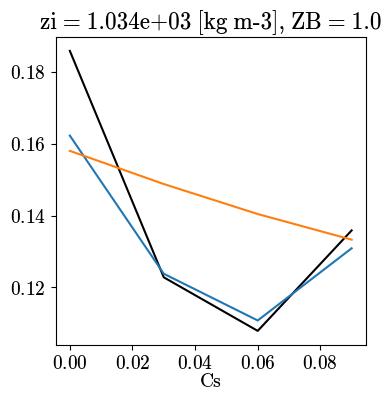

In [238]:
RMSE_grid[:,10].plot(color='k')
plt.plot(RMSE_grid.Cs, RMSE.reshape(31,4)[10,:])
plt.plot(RMSE_grid.Cs, RMSE_stupid.reshape(31,4)[10,:])

# Check calibration results

In [2]:
import xarray as xr

#metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-SECNice-Nesterov-100-spread-0.25/metrics.nc')
#metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-100-spread-0.25/metrics.nc')
#metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-MO/metrics.nc')
#metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Broyden-LM-1/metrics.nc')
#metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-e-mean-std-spread-0.1/metrics.nc')
#metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Kalman-fixed-e-mean-std-spread-0.1/metrics.nc')
metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Gradient-descent-e-mean-std-spread-0.1/metrics.nc')

hires = xr.open_dataset('../scripts/R64_R2/full.nc')
metrics['freq_r'] = hires['freq_r']

MSE_emean = ((metrics.e_mean - hires.e_mean)**2 / hires.e_mean_var_ave).sum(['xh', 'yh', 'zi'])
MSE_emean = xr.where(MSE_emean>0, MSE_emean, np.nan)

MSE_estd = ((metrics.e_std - hires.e_std)**2 / hires.e_std_var_ave).sum(['xh', 'yh', 'zi'])
MSE_estd = xr.where(MSE_estd>0, MSE_estd, np.nan)

loss_grad = MSE_emean + MSE_estd

metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-e-mean-std-spread-0.1/metrics.nc')

MSE_emean = ((metrics.e_mean - hires.e_mean)**2 / hires.e_mean_var_ave).sum(['xh', 'yh', 'zi'])
MSE_emean = xr.where(MSE_emean>0, MSE_emean, np.nan)

MSE_estd = ((metrics.e_std - hires.e_std)**2 / hires.e_std_var_ave).sum(['xh', 'yh', 'zi'])
MSE_estd = xr.where(MSE_estd>0, MSE_estd, np.nan)

loss_eki = MSE_emean + MSE_estd

metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Broyden-LM-10.0-e-mean-std-spread-0.1/metrics.nc')

MSE_emean = ((metrics.e_mean - hires.e_mean)**2 / hires.e_mean_var_ave).sum(['xh', 'yh', 'zi'])
MSE_emean = xr.where(MSE_emean>0, MSE_emean, np.nan)

MSE_estd = ((metrics.e_std - hires.e_std)**2 / hires.e_std_var_ave).sum(['xh', 'yh', 'zi'])
MSE_estd = xr.where(MSE_estd>0, MSE_estd, np.nan)

loss_LM_v1 = MSE_emean + MSE_estd

metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Broyden-LM-1.0-ver2-e-mean-std-spread-0.1/metrics.nc')

MSE_emean = ((metrics.e_mean - hires.e_mean)**2 / hires.e_mean_var_ave).sum(['xh', 'yh', 'zi'])
MSE_emean = xr.where(MSE_emean>0, MSE_emean, np.nan)

MSE_estd = ((metrics.e_std - hires.e_std)**2 / hires.e_std_var_ave).sum(['xh', 'yh', 'zi'])
MSE_estd = xr.where(MSE_estd>0, MSE_estd, np.nan)

loss_LM_v2 = MSE_emean + MSE_estd

In [3]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [4]:
ds +=  CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization', additional_subfolder='output')

In [5]:
ds +=  CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration', additional_subfolder='output')

In [6]:
ds.remesh('R64', 'R2')

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2


In [7]:
import sys
sys.path.append('../scripts')
from loss_DG import *
prog = ds['variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline'].prog
static = ds['variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline'].param
ANN_offline = variability_metrics(prog.e, prog.u, prog.v, static, compute_e = True)
prog = ds['R2'].prog
control = variability_metrics(prog.e, prog.u, prog.v, static, compute_e = True)

In [8]:
MSE_EKE_control = ((control.EKE_spectrum - hires.EKE_spectrum)**2 / hires.EKE_spectrum_var_ave).sum(['freq_r', 'zl'])
MSE_emean_control = ((control.e_mean - hires.e_mean)**2 / hires.e_mean_var_ave).sum(['xh', 'yh' ,'zi'])
MSE_estd_control = ((control.e_std - hires.e_std)**2 / hires.e_std_var_ave).sum(['xh', 'yh' ,'zi'])

In [9]:
MSE_EKE_offline = ((ANN_offline.EKE_spectrum - hires.EKE_spectrum)**2 / hires.EKE_spectrum_var_ave).sum(['freq_r', 'zl'])
MSE_emean_offline = ((ANN_offline.e_mean - hires.e_mean)**2 / hires.e_mean_var_ave).sum(['xh', 'yh' ,'zi'])
MSE_estd_offline = ((ANN_offline.e_std - hires.e_std)**2 / hires.e_std_var_ave).sum(['xh', 'yh' ,'zi'])

In [13]:
#metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Broyden-LM-10.0-e-mean-std-spread-0.1/metrics.nc')
metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Broyden-LM-1.0-ver2-e-mean-std-spread-0.1/metrics.nc')

Text(0.5, 1.0, 'STD interfaces')

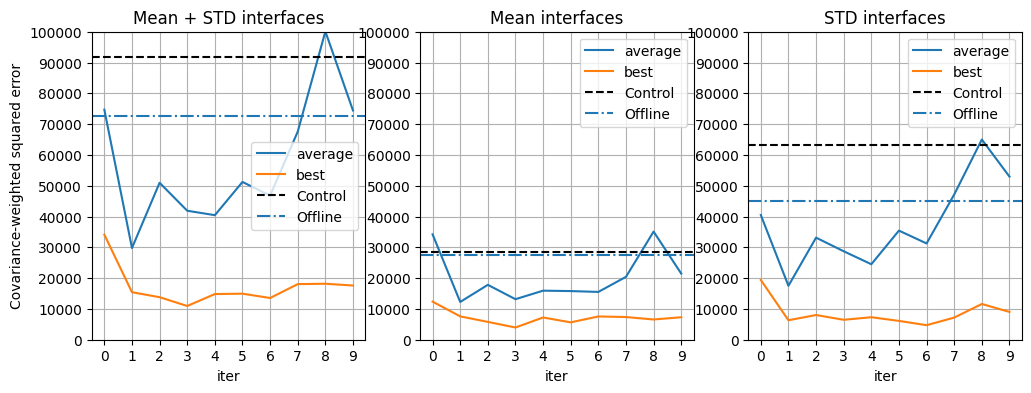

In [14]:
MSE_EKE = ((metrics.EKE_spectrum - hires.EKE_spectrum)**2 / hires.EKE_spectrum_var_ave).sum(['freq_r', 'zl'])
MSE_EKE = xr.where(MSE_EKE>0, MSE_EKE, np.nan)

MSE_emean = ((metrics.e_mean - hires.e_mean)**2 / hires.e_mean_var_ave).sum(['xh', 'yh', 'zi'])
MSE_emean = xr.where(MSE_emean>0, MSE_emean, np.nan)

MSE_estd = ((metrics.e_std - hires.e_std)**2 / hires.e_std_var_ave).sum(['xh', 'yh', 'zi'])
MSE_estd = xr.where(MSE_estd>0, MSE_estd, np.nan)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
(MSE_estd + MSE_emean).mean('ens').plot(label='average')
(MSE_estd + MSE_emean).min('ens').plot(label='best')
plt.ylabel('Covariance-weighted squared error')

plt.axhline(y=MSE_estd_control + MSE_emean_control, ls='--', label='Control', color='k')
plt.axhline(y=MSE_estd_offline + MSE_emean_offline, ls='-.', label='Offline')

plt.xticks(np.arange(10));
plt.ylim([0,100000])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000])
plt.grid()
plt.legend()
plt.title('Mean + STD interfaces')

plt.subplot(1,3,2)
MSE_emean.mean('ens').plot(label='average')
MSE_emean.min('ens').plot(label='best')
plt.axhline(y=MSE_emean_control, ls='--', label='Control', color='k')
plt.axhline(y=MSE_emean_offline, ls='-.', label='Offline')

plt.xticks(np.arange(10));
plt.ylim([0,100000])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000])
plt.grid()
plt.legend()
plt.title('Mean interfaces')

plt.subplot(1,3,3)
MSE_estd.mean('ens').plot(label='average')
MSE_estd.min('ens').plot(label='best')
plt.axhline(y=MSE_estd_control, ls='--', label='Control', color='k')
plt.axhline(y=MSE_estd_offline, ls='-.', label='Offline')

plt.xticks(np.arange(10));
plt.ylim([0,100000])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000])
plt.grid()
plt.legend()
plt.title('STD interfaces')

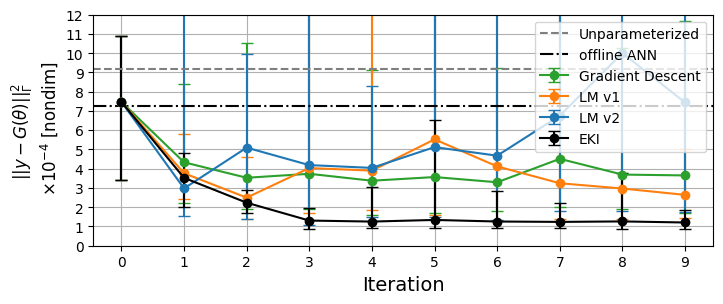

In [20]:
plt.figure(figsize=(8,3))

ymin = loss_grad.min('ens')
ymax = loss_grad.max('ens')
ymid = loss_grad.mean('ens')

yerr = np.vstack([ymid - ymin, ymax - ymid])
plt.errorbar(np.arange(10), ymid, yerr=yerr, fmt='o', capsize=4, color='tab:green', label='Gradient Descent', ls='-')

ymin = loss_LM_v1.min('ens')
ymax = loss_LM_v1.max('ens')
ymid = loss_LM_v1.mean('ens')

yerr = np.vstack([ymid - ymin, ymax - ymid])
plt.errorbar(np.arange(10), ymid, yerr=yerr, fmt='o', capsize=4, color='tab:orange', label='LM v1', ls='-')

ymin = loss_LM_v2.min('ens')
ymax = loss_LM_v2.max('ens')
ymid = loss_LM_v2.mean('ens')

yerr = np.vstack([ymid - ymin, ymax - ymid])
plt.errorbar(np.arange(10), ymid, yerr=yerr, fmt='o', capsize=4, color='tab:blue', label='LM v2', ls='-')

ymin = loss_eki.min('ens')
ymax = loss_eki.max('ens')
ymid = loss_eki.mean('ens')

yerr = np.vstack([ymid - ymin, ymax - ymid])
plt.errorbar(np.arange(10), ymid, yerr=yerr, fmt='o', capsize=4, color='k', label='EKI', ls='-')


plt.ylabel('$||y-G(\\theta)||_{\Gamma}^2$\n $\\times 10^{-4}$ [nondim]', fontsize=12)

plt.axhline(y=MSE_estd_control + MSE_emean_control, ls='--', label='Unparameterized', color='tab:gray')
plt.axhline(y=MSE_estd_offline + MSE_emean_offline, ls='-.', label='offline ANN', color='k')

plt.xticks(np.arange(10));
plt.ylim([0,100000])
plt.yticks(np.arange(13) * 10000,
          np.arange(13))
plt.xlabel('Iteration', fontsize=14)
plt.grid()
plt.legend(loc='upper right')
plt.savefig('EKI-grad-convergence-emean-estd.pdf', bbox_inches='tight')

In [152]:
loss.argmin('ens')

<xarray.DataArray (iter: 10)> Size: 80B
array([37, 98, 43, 55, 96, 71,  0, 19,  5, 87])
Dimensions without coordinates: iter

In [155]:
loss.argmax('ens')

<xarray.DataArray (iter: 10)> Size: 80B
array([26, 83, 79, 35, 48, 63, 18, 30, 13, 66])
Dimensions without coordinates: iter

In [157]:
np.abs(loss.mean('ens')-loss).argmin('ens')

<xarray.DataArray (iter: 10)> Size: 80B
array([55, 53, 75, 57, 84, 78, 77, 38, 50, 74])
Dimensions without coordinates: iter

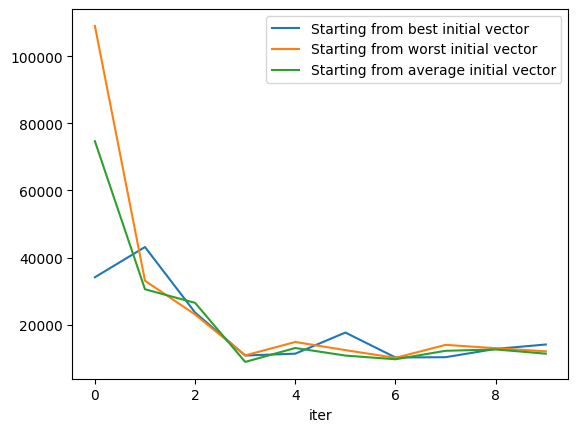

In [160]:
loss.isel(ens=37).plot(label='Starting from best initial vector')
loss.isel(ens=26).plot(label='Starting from worst initial vector')
loss.isel(ens=55).plot(label='Starting from average initial vector')
plt.legend()

# In the first EKI iteration, there is no correlation between loss during initialization and the loss after one iteration. So no heuristic decision can be made about initial condition for the optimization algorithm.

Text(0.5, 1.0, 'Correlation = -0.020450038835406303')

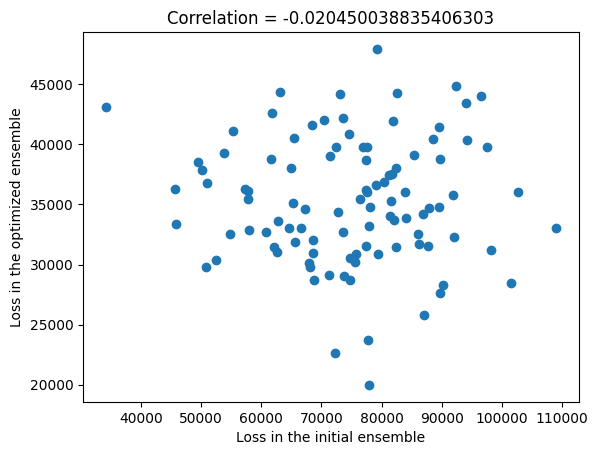

In [172]:
plt.scatter(loss.isel(iter=0), loss.isel(iter=1))
plt.xlabel('Loss in the initial ensemble')
plt.ylabel('Loss in the optimized ensemble')
corr = float(xr.corr(loss.isel(iter=0), loss.isel(iter=1)))
plt.title(f'Correlation = {corr}')

In [8]:
np.abs(loss_eki.mean('ens')-loss_eki).argmin('ens')

<xarray.DataArray (iter: 10)> Size: 80B
array([55, 53, 75, 57, 84, 78, 77, 38, 50, 74])
Dimensions without coordinates: iter

57


Text(0.5, 1.02, '3th iteration of EKI with 100 ensemble members')

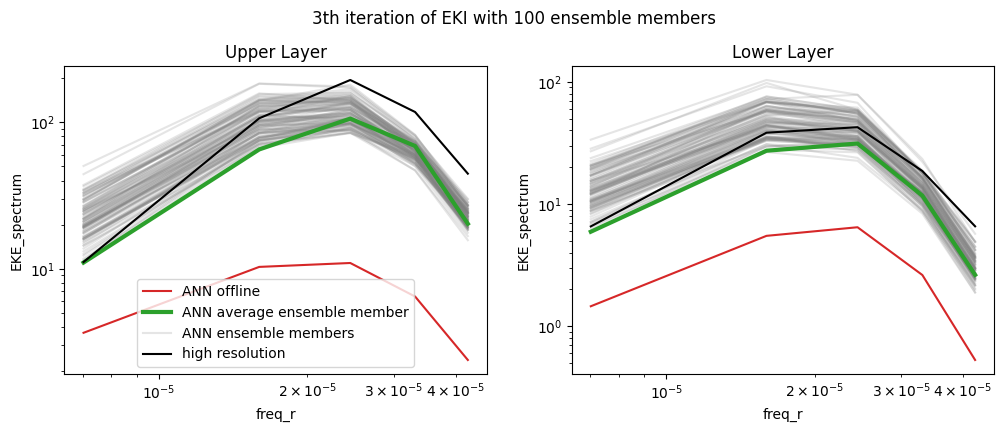

In [15]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-e-mean-std-spread-0.1/metrics.nc')

iter = 3
ens_best = 57
if ens_best is None:
    ens_best = (MSE_emean + MSE_estd)[iter].argmin()
print(int(ens_best))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for sp in metrics.EKE_spectrum[iter].isel(zl=0):
    sp.plot(color='tab:gray', alpha=0.2)
ANN_offline.EKE_spectrum.isel(zl=0).plot(color='tab:red', label='ANN offline')
metrics.EKE_spectrum[iter].isel(zl=0)[ens_best].plot(color='tab:green', label='ANN average ensemble member', lw=3)
plt.plot([np.nan],[np.nan], color='tab:gray', alpha=0.2, label='ANN ensemble members')
hires.EKE_spectrum.isel(zl=0).plot(color='k', label='high resolution', zorder=100)
plt.title('Upper Layer')

plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.subplot(1,2,2)
for sp in metrics.EKE_spectrum[iter].isel(zl=1):
    sp.plot(color='tab:gray', alpha=0.2)
ANN_offline.EKE_spectrum.isel(zl=1).plot(color='tab:red', label='ANN offline')
metrics.EKE_spectrum[iter].isel(zl=1)[ens_best].plot(color='tab:green', label='ANN average ensemble member', lw=3)
hires.EKE_spectrum.isel(zl=1).plot(color='k', label='high resolution', zorder=100)
plt.title('Lower Layer')

plt.yscale('log')
plt.xscale('log')

plt.suptitle(f'{iter}th iteration of EKI with 100 ensemble members', y=1.02)

Text(0, 0.5, 'Parameter value')

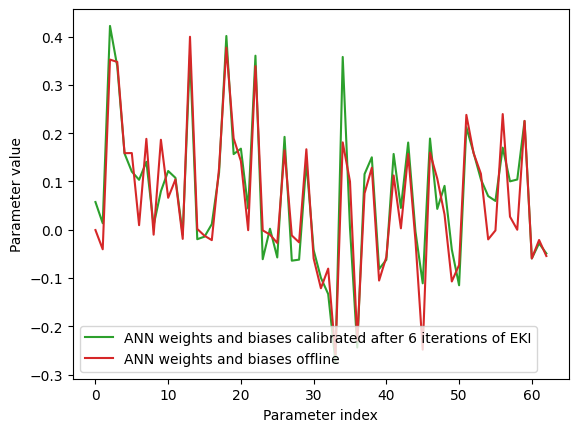

In [47]:
metrics.param[3][55].plot(label='ANN weights and biases calibrated after 6 iterations of EKI', color='tab:green')
ANN_netcdf_default = xr.open_dataset('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/EXP1/model/Tall.nc').drop_vars(['x_test', 'y_test'])
param_offline = np.concatenate([ANN_netcdf_default.A1.values.ravel(), ANN_netcdf_default.b1.values])
plt.plot(param_offline, label='ANN weights and biases offline', color='tab:red')
plt.legend()
plt.xlabel('Parameter index')
plt.ylabel('Parameter value')

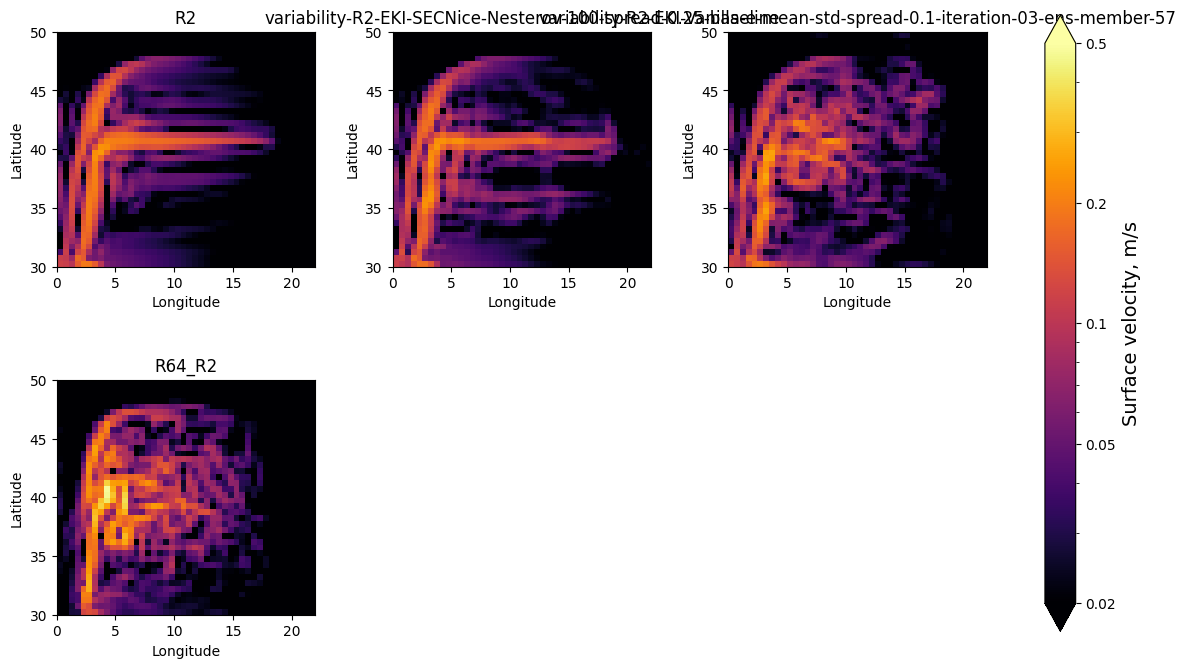

In [16]:
ds.plot_velocity_snapshot(['R2', 
                           'variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline',  
                           'variability-R2-EKI-Vanilla-e-mean-std-spread-0.1-iteration-03-ens-member-57', 
                           'R64_R2'], idx=100)

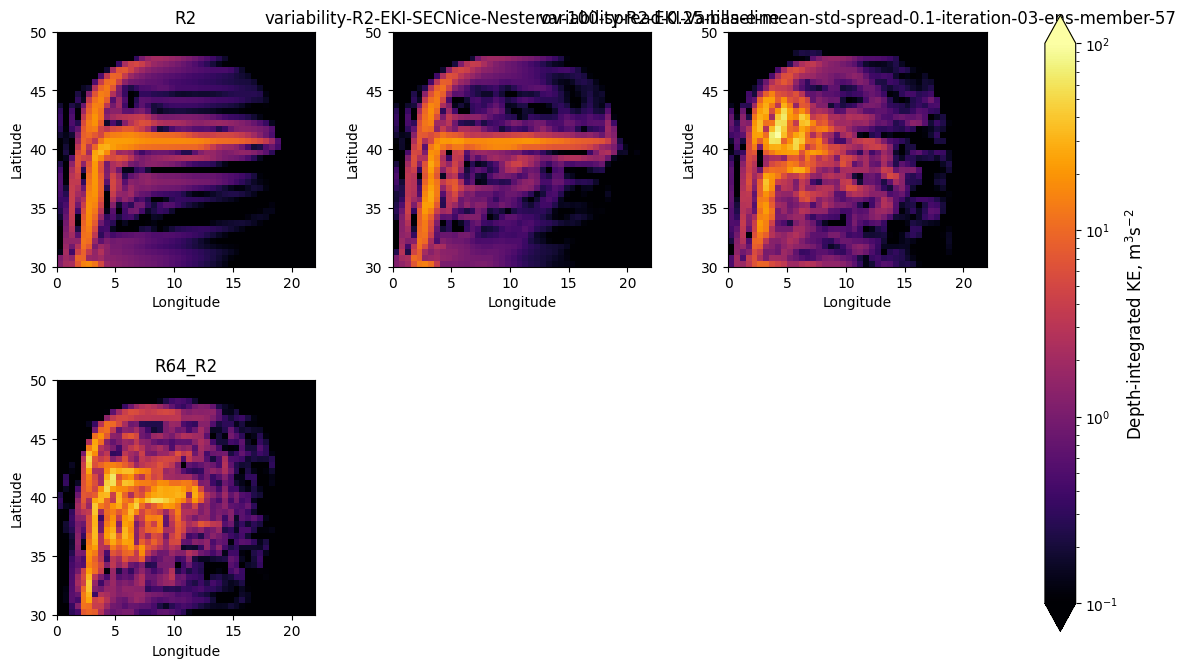

In [167]:
ds.plot_logKEz(['R2', 
               'variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline',  
               'variability-R2-EKI-Vanilla-e-mean-std-spread-0.1-iteration-03-ens-member-57', 
               'R64_R2'], idx=-1)

In [78]:
loss = MSE_estd + MSE_emean

In [134]:
loss.argmin('ens')

<xarray.DataArray (iter: 10)> Size: 80B
array([37, 98, 43, 55, 96, 71,  0, 19,  5, 87])
Dimensions without coordinates: iter

In [97]:
# Finding the best experiment so far
subset = loss.isel(iter=slice(0,4))
np.unravel_index(subset.argmin(), subset.shape)

(3, 55)

In [129]:
def plot(idx=0):
    iteration = idx // 60 - 1
    if iteration == -1:
        exp = 'variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline'
    else:
        subset = loss.isel(iter=slice(0,iteration+1))
        i, e = np.unravel_index(subset.argmin(), subset.shape)
        print(i,e)
        exp = f'variability-R2-EKI-Vanilla-e-mean-std-spread-0.1-iteration-{i:02d}-ens-member-{e:02d}'
        
    if iteration==-1:
        label = 'offline ANN'
    elif iteration==0:
        label = 'random ANN (iteration=0)'
    elif iteration>0:
        label = f'optimized ANN (iteration={iteration})'

    ds.plot_velocity_snapshot(['R2', exp, 'R64_R2'], idx=idx%60 + 60,
                  labels = ['Unparameterized', label, 'Hires coarsegrained'])
    

8 5


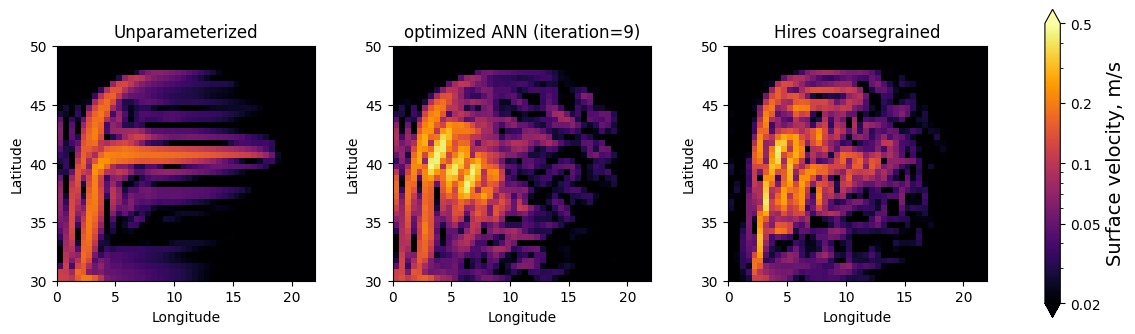

In [131]:
plot(idx=60*10+59)

In [132]:
create_animation_ffmpeg(plot, np.arange(60*11), filename='ANN-optimized-estd-emean-surf-vel.mp4', FPS=15)

Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-0.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-1.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-2.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-3.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-4.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-5.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-6.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-7.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-8.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-9.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-10.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-11.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-12.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-13.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-14.png
Savefig .ffmpeg/ANN-optimized-estd-emean-surf-vel/frame-15.png
Sa

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

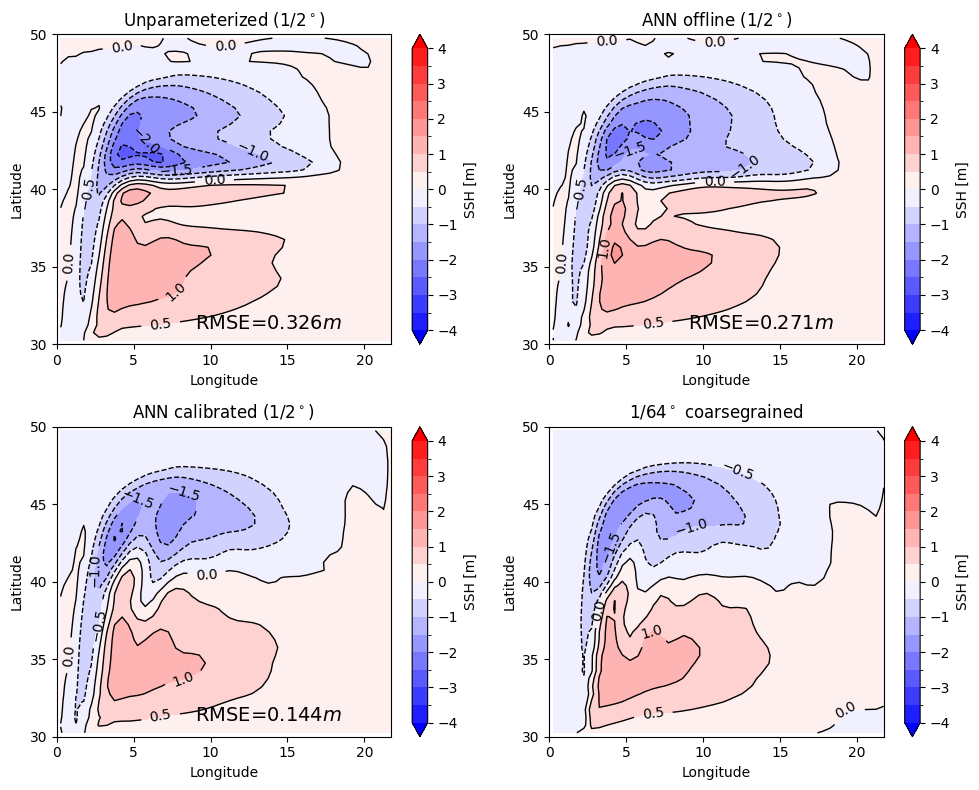

In [23]:
ds.plot_ssh(['R2', 'variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline',  'variability-R2-EKI-Vanilla-e-mean-std-spread-0.1-iteration-03-ens-member-57', 'R64_R2'],
           labels=['Unparameterized ($1/2^\circ$)', 'ANN offline ($1/2^\circ$)', 'ANN calibrated ($1/2^\circ$)', '$1/64^\circ$ coarsegrained'], ncols=2)

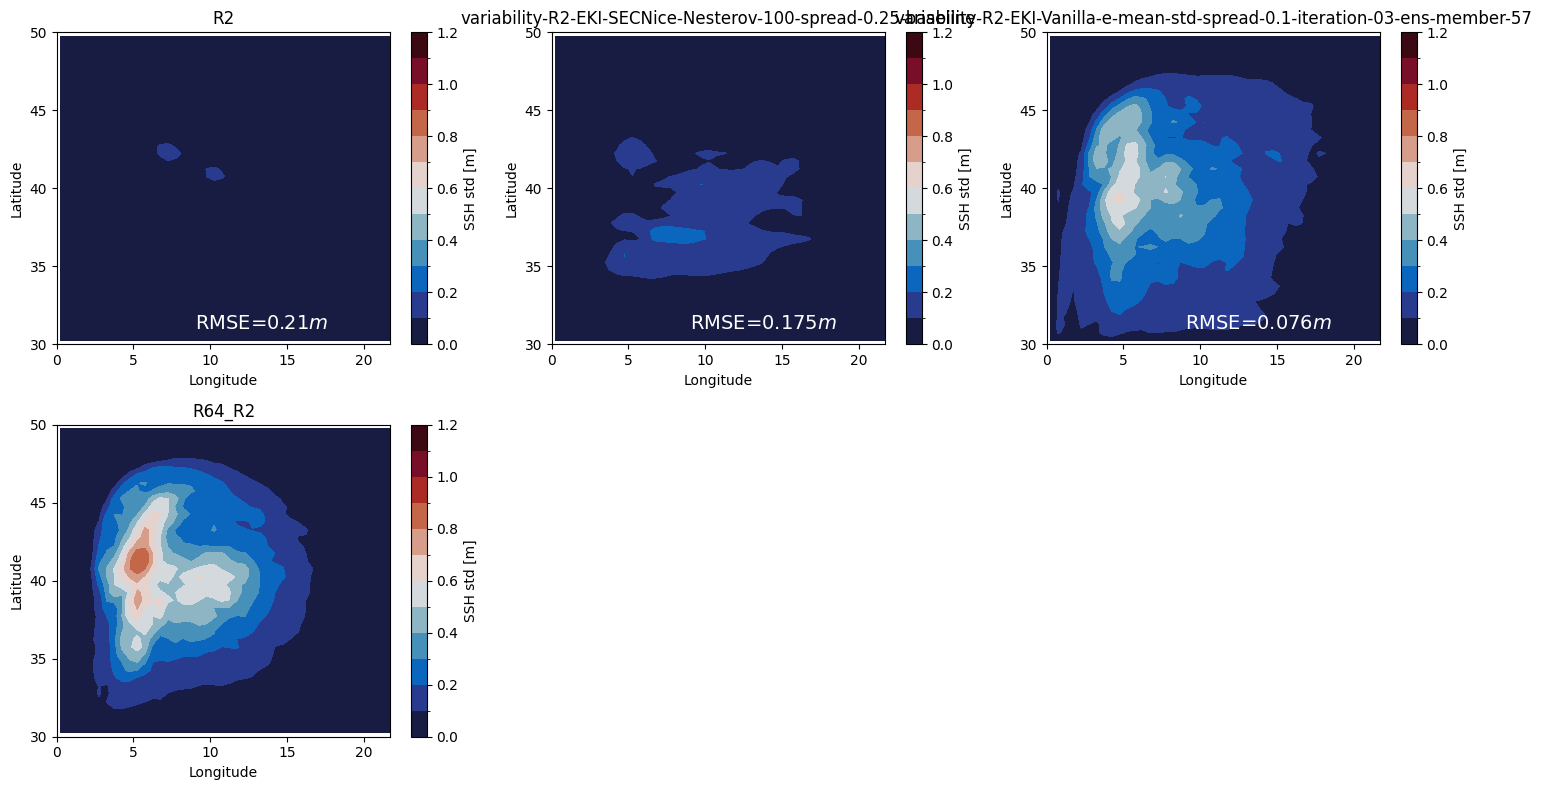

In [165]:
ds.plot_ssh_std(['R2', 'variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline',  'variability-R2-EKI-Vanilla-e-mean-std-spread-0.1-iteration-03-ens-member-57', 'R64_R2'])

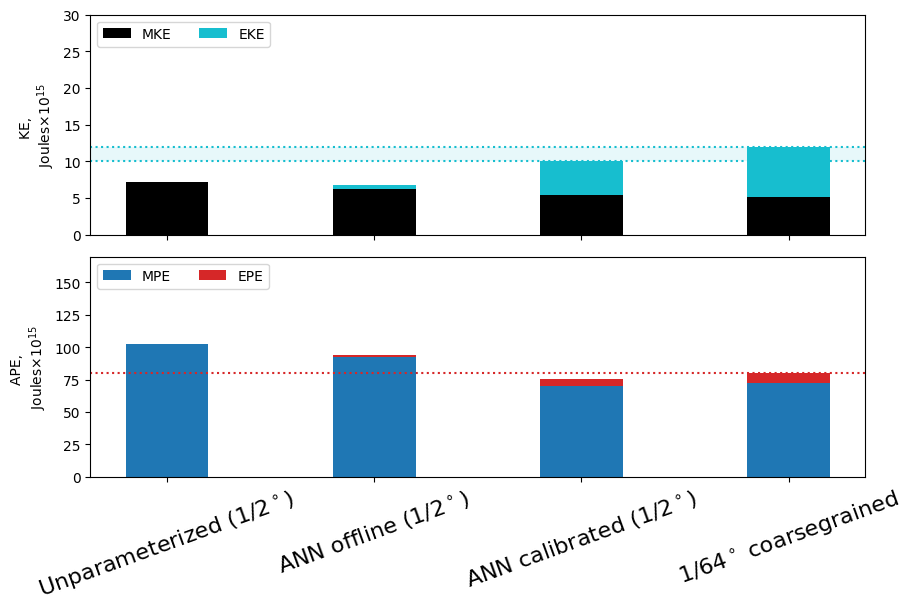

In [24]:
ds.plot_KE_PE_simpler(['R2', 'variability-R2-EKI-SECNice-Nesterov-100-spread-0.25-baseline', 'variability-R2-EKI-Vanilla-e-mean-std-spread-0.1-iteration-03-ens-member-57', 'R64_R2'],
                     labels=['Unparameterized ($1/2^\circ$)', 'ANN offline ($1/2^\circ$)', 'ANN calibrated ($1/2^\circ$)', '$1/64^\circ$ coarsegrained'])

# Test writing correct weights file

In [59]:
ENS_SPREAD = 0.
ANN_netcdf_default = xr.open_dataset('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/EXP1/model/Tall.nc').drop_vars(['x_test', 'y_test'])
N_ensemble = 100

# Initial ensemble for EKI
A1_mean = ANN_netcdf_default['A1'].values.reshape(-1)
b1_mean = ANN_netcdf_default['b1'].values.reshape(-1)
A1_std = ENS_SPREAD * ANN_netcdf_default['A1'].values.std()
b1_std = ENS_SPREAD * ANN_netcdf_default['b1'].values.std()


In [60]:
np.random.seed(0)
# 63 x 100 matrix
# Where 63 is the number of free parameters and 100 is the ensemble size
# Note: we do computations here in float64, but later convert to float32 for online experiments
initial_ensemble = np.concatenate([A1_mean, b1_mean]).reshape(-1,1) + np.concatenate([A1_std * np.random.randn(len(A1_mean), N_ensemble), b1_std * np.random.randn(len(b1_mean), N_ensemble)]).astype('float64')


In [68]:
params=initial_ensemble
for ens_member, param in enumerate(params.T):
    A1 = param[:-3]
    b1 = param[-3:]
    ANN_netcdf = ANN_netcdf_default.copy()
    ANN_netcdf['A1'] = ANN_netcdf['A1']*0 + A1.reshape([20,3]).astype('float32').copy()
    ANN_netcdf['b1'] = ANN_netcdf['b1']*0 + b1.astype('float32').copy()

In [71]:
ANN_netcdf - ANN_netcdf_default

<xarray.Dataset> Size: 3kB
Dimensions:       (dummy_dimension: 1, nlayers: 3, ncol0: 27, nrow0: 20,
                   ncol1: 20, nrow1: 3)
Dimensions without coordinates: dummy_dimension, nlayers, ncol0, nrow0, ncol1,
                                nrow1
Data variables:
    num_layers    (dummy_dimension) int32 4B 0
    layer_sizes   (nlayers) int32 12B 0 0 0
    A0            (ncol0, nrow0) float32 2kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b0            (nrow0) float32 80B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    A1            (ncol1, nrow1) float32 240B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    b1            (nrow1) float32 12B 0.0 0.0 0.0
    input_norms   (ncol0) float32 108B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    output_norms  (nrow1) float32 12B 0.0 0.0 0.0

In [120]:
# data = xr.open_dataset('/home/pp2681/calibration/scripts/R64_R2/variability-2-degrees.nc').isel(zi=slice(0,2)).drop_vars(['e_std_weight', 'EKE_spectrum_weight']).load()
# data['EKE_spectrum_var_ave'] = data.EKE_spectrum_var.mean('freq_r') + data.EKE_spectrum_var*0
# data['e_std_var_ave'] = data.e_std_var.mean(['xh','yh']) +  data.e_std_var*0
# data.to_netcdf('/home/pp2681/calibration/scripts/R64_R2/variability-2-degrees.nc')

In [121]:
data

<xarray.Dataset> Size: 3kB
Dimensions:               (zi: 2, yh: 10, xh: 11, zl: 2, freq_r: 5)
Coordinates:
  * yh                    (yh) float64 80B 31.0 33.0 35.0 ... 45.0 47.0 49.0
  * xh                    (xh) float64 88B 1.0 3.0 5.0 7.0 ... 17.0 19.0 21.0
  * zi                    (zi) float64 16B 1.034e+03 1.036e+03
  * zl                    (zl) float64 16B 1.035e+03 1.036e+03
  * freq_r                (freq_r) float64 40B 7.022e-06 1.597e-05 ... 4.235e-05
Data variables:
    e_std                 (zi, yh, xh) float32 880B ...
    EKE_spectrum          (zl, freq_r) float32 40B ...
    e_std_var             (zi, yh, xh) float32 880B ...
    EKE_spectrum_var      (zl, freq_r) float32 40B ...
    EKE_spectrum_var_ave  (zl, freq_r) float32 40B ...
    e_std_var_ave         (zi, yh, xh) float32 880B 0.0001402 ... 0.8687

# Test Broyden step by step

In [28]:
import os
import sys
sys.path.append('../scripts')
import numpy as np
import xarray as xr
from slurm_DG import *
from loss_DG import *
import argparse


TAG = 'brd'
hpc = HPC.add(name=TAG, time=1, ntasks=3, begin='1minute', executable='/scratch/pp2681/MOM6-examples/build/compiled_executables/MOM6-dev-m2lines-Aug18')
base_path = '/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2'
optimization_folder = 'Broyden-LM-1'


In [29]:
np.random.seed(0)

In [30]:
# Model configuration
ANN_params = PARAMETERS.add(**configuration('R2')).add(DAYMAX=3650.0).add(USE_ZB2020='True',ZB2020_USE_ANN='True',ZB2020_ANN_FILE_TALL='INPUT/Tall.nc',USE_CIRCULATION_IN_HORVISC='True')
# Read necessary NETCDF files
ANN_netcdf_default = xr.open_dataset('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/EXP1/model/Tall.nc').drop_vars(['x_test', 'y_test'])
# Read observation vector
observation = xr.open_dataset('/home/pp2681/calibration/scripts/R64_R2/variability-2-degrees.nc')

# Broyden configuration
# As Broyden method converges very fast, 5 iterations should be enough.
# Also, because Broyden method reduces step length if Jacobian is noisy,
# We will likely see a stagnation of iteration pretty soon. Nevertheless
# To investigate the convergence properties, we will do 10 iterations.
# This might be justified by the fact that the optimization problem
# is strongly nonlinear.
N_iterations = 10
# We understand the ensemble size of Broyden method as the number of initial conditions
# used to restart the iteration.
# For simplicity, we start with the simplest approach or random sampling.
N_ensemble = 92
# Note that starting from a few best points or a few points closest to the 
# untuned model might be preferable to explore in future

# Observation vector for Broyden method
# 10 values of EKE spectrum
y = (observation.EKE_spectrum).values.ravel().astype('float64')

OBS_AND_FORWARD_FACTOR = 2.
y_var = OBS_AND_FORWARD_FACTOR * (observation.EKE_spectrum_var_ave).values.ravel().astype('float64')
# Inverse Matrix of obs+model error covariance
Gamma_inv = np.diag(1./y_var)

LM_lambda = 1.

In [31]:
initial_ensemble = xr.open_dataset(f'{base_path}/{optimization_folder}/initial_ensemble.nc')
# Forming initial approximation of the Jacobian using all available data
# arrays of size N_params x ens_size
initial_ens_size = len(initial_ensemble.ens)
params = np.array(initial_ensemble['param']).astype('float64').T
g_ens =  np.array(initial_ensemble['EKE_spectrum']).reshape([initial_ens_size, -1]).astype('float64').T

# find ensemble members (columns) that contain NaNs
bad_mask = np.any(np.isnan(g_ens), axis=0)

# keep only good members
params = params[:, ~bad_mask]
g_ens = g_ens[:, ~bad_mask]
initial_ens_size = params.shape[-1]

mean=lambda x: x.mean(axis=-1,keepdims=True)
cov_xx = (params-mean(params)) @ (params-mean(params)).T / initial_ens_size
# We know that the initial ensemble is sampled from gaussian disttibution
# with independent random variables along each parameter.
# Thus, such Jacobian estimator is simply equivalent to fitting the linear
# slope to a scatter plot of parameter_i x observation_component_j
# Such slope estimation is very similar to estimation of slope with finite differences
# Estimation in such form is very simple to analyze analytically
# This feature probably was found only to destroy the computation
#cov_xx = np.diag(np.diag(cov_xx))
cov_yx = (g_ens-mean(g_ens))   @ (params-mean(params)).T / initial_ens_size

# Initial Jacobian computed from big ensemble
cov_xx_inv = np.linalg.pinv(cov_xx, rcond=1e-8)
J_initial = cov_yx @ cov_xx_inv

# Forming set of initial conditions
idx = np.sort(np.random.choice(initial_ens_size, N_ensemble, replace=False))
print('Initial ensemble indices:', idx)
# N_params x N_ensemble
# Here we choose among ensemble members which did not explode
params = params[:,idx]
g_ens = g_ens[:, idx]
J_ens = np.stack([J_initial.copy() for _ in range(N_ensemble)], axis=2)
print(params.shape, g_ens.shape, J_ens.shape)

metrics = xr.Dataset()
nzl = 2
nfreq_r = 5
metrics['EKE_spectrum'] = xr.DataArray(np.nan * np.zeros([N_iterations, N_ensemble, nzl, nfreq_r]), dims=['iter', 'ens', 'zl', 'freq_r'])
metrics['param'] = xr.DataArray(np.nan * np.zeros([N_iterations, N_ensemble, 63]), dims=['iter', 'ens', 'pdim'])
metrics['EKE_spectrum'][0,:,:,:] = initial_ensemble['EKE_spectrum'][~bad_mask][idx]
metrics['param'][0,:,:] = initial_ensemble['param'][~bad_mask][idx]

Initial ensemble indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
(63, 92) (10, 92) (10, 63, 92)


In [32]:
delta_params = np.zeros_like(params)
for ens_member in range(N_ensemble):
    param = params[:,ens_member]
    g = g_ens[:,ens_member]
    J = J_ens[:,:,ens_member]
    # Here, we can think of pinv as Levenberg-Marquardt update with
    # regularization parameter approaching zero. Because uninvertible
    # matrix can potentially lead to infinitely large parameter update,
    # we can see this as a natural damping regularization where Levenberg-Marquardt
    # suggests infinitely small parameter updates with infinite regularization parameter
    delta_params[:,ens_member] = np.linalg.pinv(J.T@Gamma_inv@J + LM_lambda * cov_xx_inv, rcond=1e-8)@(J.T@Gamma_inv@(y - g))
    # Note: a good property of the good Broyden method is that there is no
    # scalar product in the observational space. Thus, we do not need to
    # account for Gamma matrix in the Jacobian update. 
params = params + delta_params

In [34]:
iteration=1
iteration_path = f'{base_path}/{optimization_folder}/iteration-{iteration:02d}'
params_file = f'{iteration_path}-params.txt'

In [35]:
if np.isnan(params).sum() == params.size:
    print('All parameters are NaNs. Stopping the optimization')
    sys.exit(1)   # terminate immediately with error code

if not(os.path.exists(params_file)):
    print('Saving parameters to file', params_file)
    np.savetxt(params_file, params)
else:
    params_old = np.loadtxt(params_file)
    if not(np.allclose(np.nan_to_num(params,1e+30), np.nan_to_num(params_old,1e+30))):
        print('Parameters changed! Check the optimization algorithm.')
        sys.exit(1)   # terminate immediately with error code
    else:
        print('Parameters are the same. Keep going...')

Parameters are the same. Keep going...


In [42]:
if os.path.exists(iteration_path):
    print('Folder with experiments exists')
    ens_member = 18
    ds = xr.open_mfdataset(f'{iteration_path}/ens-member-{ens_member:02d}/output/prog_*.nc', decode_times=False)
    static = xr.open_mfdataset(f'{iteration_path}/ens-member-{ens_member:02d}/output/ocean_geometry.nc', decode_times=False).rename({'lonh': 'xh', 'lath': 'yh'})
    data = variability_metrics(ds.e, ds.u, ds.v, static)
    
    g = (data.EKE_spectrum).values.ravel().astype('float64')
    delta_g = g - g_ens[:,ens_member]
    delta_p = delta_params[:,ens_member]
    J = J_ens[:,:,ens_member]
    # Update Jacobian with good Broyden formula
    print(delta_g.shape, delta_p.shape, J.shape)
    J_ens[:,:, ens_member] += np.outer(delta_g-J@delta_p, delta_p) / np.dot(delta_p,delta_p)
    # Update g_ens
    g_ens[:,ens_member] = g
    # Note: parameter vector is already update above

    print(f'Ensemble member {ens_member} succesfully ingested')

    metrics['EKE_spectrum'][iteration][ens_member] = data.EKE_spectrum
        
    print('Forward model evaluations are passed through Broyden Jacobian update. Going to the next iterations...')

Folder with experiments exists
(10,) (63,) (10, 63)
Ensemble member 18 succesfully ingested
Forward model evaluations are passed through Broyden Jacobian update. Going to the next iterations...


# Check how Broyden is close to Vanilla EKI

In [100]:
broyden = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Broyden-LM-1/metrics.nc').load()

In [101]:
eki = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-100-spread-0.25/metrics.nc').load()

In [102]:
# Initialization
print(broyden.param[0][0].values)
print(eki.param[0][1].values)


[ 1.3769174e-02 -8.9095227e-02  3.4371877e-01  4.0729898e-01
  1.1833780e-01  1.5756415e-01  2.4448266e-02  1.4460273e-01
  1.8080886e-02  1.6170982e-01  9.8306350e-02  1.0298949e-01
 -8.9711986e-02  3.8332406e-01  3.3146285e-02 -1.6898429e-02
 -2.6948044e-02  1.0977210e-01  3.6698118e-01  1.8491650e-01
  8.0468625e-02  1.2546269e-02  3.2040861e-01 -1.9180829e-02
 -2.3581902e-02 -6.8579093e-03  1.6388789e-01 -9.4252698e-02
 -8.8526092e-02  1.5049511e-01 -3.8864344e-02 -1.3106297e-01
 -6.7267373e-02 -2.8391486e-01  1.6043288e-01  1.5193643e-01
 -2.2560287e-01  1.3864759e-01  1.2179223e-01 -1.3421264e-01
  1.0049987e-02  1.1064205e-01  2.5677649e-02  1.6980444e-01
 -3.3117026e-02 -2.5679880e-01  1.6353251e-01  1.0132572e-01
 -7.4465983e-03 -8.4596790e-02 -9.9667192e-02  2.1864879e-01
  1.4396907e-01  1.0892227e-01 -1.3891618e-04  1.8887004e-02
  2.4799412e-01  1.2158098e-02  2.5674267e-02  2.2385785e-01
 -6.3419029e-02 -2.1994164e-02 -5.7378270e-02]
[ 1.3769174e-02 -8.9095227e-02  3.4371

In [103]:
# 1st iteration. Step in parameter space
print((broyden.param[1][0] - broyden.param[0][0]).values)
print((eki.param[1][1] - eki.param[0][1]).values)

[ 0.02293838  0.0384516   0.01116592  0.05358505  0.06070905 -0.02084012
 -0.03071233 -0.06933311 -0.04349753 -0.05350999  0.04253132 -0.03226735
 -0.03588208 -0.01626247 -0.03411665 -0.0410348   0.01337125  0.00736997
 -0.02610603 -0.06509833  0.00314549  0.05903054  0.02204812 -0.01337039
 -0.095683    0.00370354  0.02937101 -0.04368245 -0.00626051  0.0428734
 -0.00869268  0.00574119 -0.01048723 -0.05167469 -0.03255872 -0.04305022
 -0.01052007 -0.00156774  0.00851595  0.05020369 -0.00592418  0.0057838
  0.01931553  0.01645513  0.02302568  0.01443785 -0.00216107 -0.0036422
 -0.0307873   0.00536916 -0.02161101  0.00845706 -0.02572642  0.01331047
  0.00636011 -0.0028347   0.02833191 -0.00637141  0.07540777 -0.0206383
  0.00118119  0.00486672 -0.00466696]
[ 0.02210512  0.03686272  0.00761822  0.05066884  0.05272102 -0.01659416
 -0.03152576 -0.0627133  -0.03852322 -0.04811899  0.03956605 -0.03041983
 -0.03331916 -0.01790977 -0.02764044 -0.03713963  0.01273537  0.01151881
 -0.02543163 -0.0

(-0.2, 0.2)

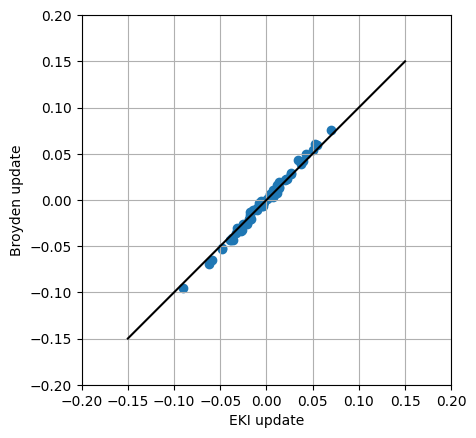

In [105]:
plt.scatter((eki.param[1][1] - eki.param[0][1]).values, (broyden.param[1][0] - broyden.param[0][0]).values)
plt.xlabel('EKI update')
plt.ylabel('Broyden update')
#plt.plot([-0.15, 0.15], np.array([-0.15, 0.15])*1.6, color='tab:gray')
plt.plot([-0.15, 0.15], np.array([-0.15, 0.15])*1.0, color='k')
plt.grid()
plt.gca().set_aspect(1)
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])

# Compare parameter prediction for 1 step EKI vs Broyden

In [119]:
eki = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-e-mean-std-spread-0.1/metrics.nc')

In [97]:
broyden = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Broyden-LM-1.0-full-cov-xx-e-mean-std-spread-0.1/metrics.nc')

In [86]:
descent = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Gradient-descent-e-mean-std-spread-0.1/metrics.nc')

In [4]:
eki_fixed = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/Kalman-fixed-e-mean-std-spread-0.1/metrics.nc')

In [104]:
np.linalg.norm(eki.param[1] - broyden.param[1])

9.320187e-07

In [87]:
param_mean = xr.DataArray(param_mean, dims='pdim')
param_std = xr.DataArray(param_std, dims='pdim')

In [88]:
np.sqrt(((eki.param - param_mean)**2 / param_std**2).mean(['pdim', 'ens']))

<xarray.DataArray (iter: 10)> Size: 80B
array([0.98701927, 2.99245287, 3.39095291, 3.72222932, 3.83824714,
       3.82853564, 3.82260655, 3.82742443, 3.83347212, 3.83118307])
Dimensions without coordinates: iter

In [89]:
np.sqrt(((descent.param - param_mean)**2 / param_std**2).mean(['pdim', 'ens']))

<xarray.DataArray (iter: 10)> Size: 80B
array([0.98701927, 1.10004589, 1.14622771, 1.18791618, 1.44334652,
       1.47878866, 1.68175825, 1.56124854, 2.15128115, 1.30115141])
Dimensions without coordinates: iter

In [96]:
np.sqrt(((broyden.param - param_mean)**2 / param_std**2).mean(['pdim', 'ens']))

<xarray.DataArray (iter: 10)> Size: 80B
array([0.98701927, 3.82727048,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])
Dimensions without coordinates: iter

In [115]:
(np.abs(eki.param - param_mean) / param_std).isel(iter=0, ens=0)

<xarray.DataArray (pdim: 63)> Size: 504B
array([1.76, 1.88, 0.37, 1.31, 0.6 , 0.38, 1.55, 1.44, 1.41, 1.46, 0.56,
       1.1 , 0.9 , 1.45, 0.47, 0.01, 0.43, 1.56, 0.82, 0.03, 1.53, 0.  ,
       0.86, 0.27, 0.15, 1.62, 0.6 , 1.91, 0.97, 1.32, 1.59, 1.12, 1.33,
       1.85, 1.91, 0.34, 0.53, 0.41, 0.1 , 0.72, 0.61, 1.71, 0.05, 0.2 ,
       0.34, 1.07, 1.78, 1.81, 0.41, 1.36, 0.31, 0.24, 0.47, 0.78, 0.58,
       0.76, 0.6 , 1.47, 0.59, 0.71, 2.04, 1.43, 0.04])
Dimensions without coordinates: pdim

In [121]:
(np.abs(eki.param - param_mean) / param_std).isel(iter=-1, ens=0)

<xarray.DataArray (pdim: 63)> Size: 504B
array([ 3.93,  3.64,  4.9 ,  1.34,  0.63,  3.02,  6.51,  2.65,  2.7 ,
        7.28,  4.04,  0.73,  1.39,  2.32,  0.45,  0.11,  3.49,  0.58,
        1.74,  1.67,  2.01,  3.23,  2.07,  4.52,  0.44,  2.96,  2.33,
        3.93,  1.69,  0.92,  0.59,  0.63,  3.48,  0.64, 12.39,  6.66,
        1.6 ,  3.32,  0.8 ,  2.73,  0.39,  3.8 ,  3.66,  1.79,  0.13,
       10.14,  2.57,  4.09,  4.26,  4.41,  2.63,  1.95,  0.8 ,  0.19,
        5.59,  3.88,  5.33,  4.93,  7.76,  0.69,  0.8 ,  4.9 ,  3.57])
Dimensions without coordinates: pdim

In [127]:
eki.param[-1][0] - param_mean

<xarray.DataArray (pdim: 63)> Size: 252B
array([ 0.06,  0.05,  0.07, -0.02,  0.01, -0.04,  0.09, -0.04,  0.04,
       -0.11,  0.06,  0.01,  0.02, -0.03, -0.01, -0.  ,  0.05, -0.01,
        0.03, -0.02,  0.03,  0.05,  0.03, -0.07,  0.01, -0.04,  0.03,
       -0.06, -0.02, -0.01,  0.01,  0.01, -0.05, -0.01,  0.18, -0.1 ,
       -0.02,  0.05,  0.01,  0.04, -0.01,  0.05,  0.05,  0.03,  0.  ,
        0.15,  0.04, -0.06,  0.06,  0.06, -0.04, -0.03,  0.01, -0.  ,
        0.08,  0.06, -0.08,  0.07,  0.11,  0.01,  0.  , -0.01,  0.01],
      dtype=float32)
Dimensions without coordinates: pdim

In [128]:
param_std

<xarray.DataArray (pdim: 63)> Size: 504B
array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  ])
Dimensions without coordinates: pdim

In [112]:
(eki.param.std('ens') / param_std).mean(['pdim'])

<xarray.DataArray (iter: 10)> Size: 80B
array([0.98, 0.58, 0.37, 0.24, 0.11, 0.05, 0.03, 0.01, 0.01, 0.  ])
Dimensions without coordinates: iter

In [135]:
np.sqrt(((broyden.param - param_mean)**2 / param_std**2).mean(['pdim', 'ens']))

<xarray.DataArray (iter: 10)> Size: 80B
array([0.99, 3.88,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
Dimensions without coordinates: iter

In [123]:
np.sqrt(((eki_fixed.param - param_mean)**2 / param_std**2).mean(['pdim', 'ens']))

<xarray.DataArray (iter: 10)> Size: 80B
array([0.99, 2.99, 5.56, 7.27,  nan,  nan,  nan,  nan,  nan,  nan])
Dimensions without coordinates: iter

In [120]:
deki = eki.param[1] - eki.param[0]

In [472]:
dbroyden = broyden.param[2] - broyden.param[1]

In [473]:
dekif = eki_fixed.param[2] - eki_fixed.param[1]

(-0.2, 0.2)

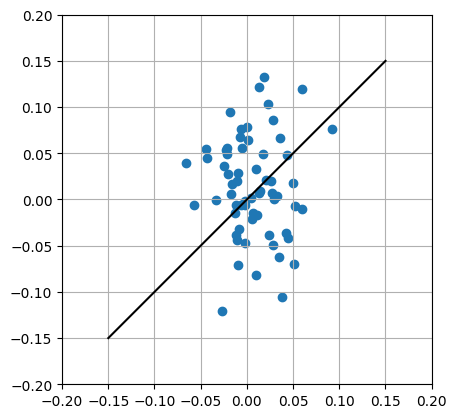

In [475]:
plt.scatter(deki[0].data.ravel(), dbroyden[0].data.ravel())
plt.plot([-0.15, 0.15], np.array([-0.15, 0.15])*1.0, color='k')
plt.grid()
plt.gca().set_aspect(1)
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])

# Test the code line by line

In [87]:
observation = xr.open_dataset('/home/pp2681/calibration/scripts/R64_R2/full.nc')

N_iterations = 10
N_ensemble = 100

# See "Iterative Ensemble Kalman Methods: A Unified Perspective with Some New Variants"
# 3.7-3.8 equations

# Observation vector for EKI
# 220 values of ssh mean
y1 = (observation.e_mean).values.ravel().astype('float64')
# 220 values of ssh std
y2 = (observation.e_std).values.ravel().astype('float64')
y = np.concatenate([y1,y2])

OBS_AND_FORWARD_FACTOR = 2.
# We multiply the noise variance of spatial field by this factor to
# reduce its contribution to the loss related to different number of elements (i.e., MSE instead of SSE)
var1 = (observation.e_mean_var_ave).values.ravel().astype('float64')
var2 = (observation.e_std_var_ave).values.ravel().astype('float64')
var_diag = OBS_AND_FORWARD_FACTOR * np.concatenate([var1, var2])
Gamma_inv = np.diag(1 / var_diag)
Gamma = np.diag(var_diag)

In [88]:
initial_ensemble = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2/EKI-Vanilla-e-mean-std-spread-0.1/metrics.nc').isel(iter=0)
# Forming initial approximation of the Jacobian using all available data
# arrays of size N_params x ens_size
initial_ens_size = len(initial_ensemble.ens)
params = np.array(initial_ensemble['param']).astype('float64').T
g_ens =  np.vstack([np.array(initial_ensemble['e_mean']).reshape([initial_ens_size, -1]).astype('float64').T,
                    np.array(initial_ensemble['e_std'] ).reshape([initial_ens_size, -1]).astype('float64').T])

In [89]:
g_ens.shape

(440, 100)

In [90]:
initial_ensemble_size = 100

In [91]:
mean=lambda x: x.mean(axis=-1,keepdims=True)
cov_xx = (params-mean(params)) @ (params-mean(params)).T / initial_ens_size

In [92]:
cov_yx = (g_ens-mean(g_ens))   @ (params-mean(params)).T / initial_ens_size
cov_xy = cov_yx.T
cov_yy = (g_ens-mean(g_ens))   @ (g_ens-mean(g_ens)).T / initial_ens_size

In [93]:
J_initial = cov_yx @ np.linalg.pinv(cov_xx, rcond=1e-8)
K_initial = cov_xy @ np.linalg.pinv(cov_yy + Gamma, rcond=1e-8)
#J_initial = np.linalg.pinv(cov_xy @ np.linalg.pinv(cov_yy + Gamma, rcond=1e-8))

In [117]:
J_new = cov_yy @ np.linalg.pinv(cov_xy)
cov_xx_new = cov_xy @ np.linalg.pinv(J_new.T)

In [94]:
ENS_SPREAD = 0.1
ANN_netcdf_default = xr.open_dataset('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/EXP1/model/Tall.nc').drop_vars(['x_test', 'y_test'])
A1_std = ENS_SPREAD * ANN_netcdf_default['A1'].values.std()
b1_std = ENS_SPREAD * ANN_netcdf_default['b1'].values.std()
A1_mean = ANN_netcdf_default['A1'].values.reshape(-1)
b1_mean = ANN_netcdf_default['b1'].values.reshape(-1)

param_mean = np.concatenate([A1_mean, b1_mean])
param_std = np.concatenate([A1_std * np.ones(60), b1_std * np.ones(3)])

In [95]:
#cov_xx_inv = np.diag(1 / np.concatenate([A1_std**2 * np.ones(60), b1_std**2 * np.ones(3)]))
cov_xx_inv = np.linalg.inv(np.diag(np.diag(cov_xx)))

In [96]:
N_ensemble=100
J_ens = np.stack([J_initial.copy() for _ in range(N_ensemble)], axis=2)

In [125]:
iteration = 1
LM_lambda = 1
print(f'################ iteration {iteration} ####################')
# Query parameter vector to compute
delta_params = np.zeros_like(params)
delta_params2 = np.zeros_like(params)
for ens_member in range(N_ensemble):
    param = params[:,ens_member]
    g = g_ens[:,ens_member]
    #J = J_ens[:,:,ens_member]
    J = J_new
    cov_xx = cov_xx_new
    cov_xx_inv = np.linalg.pinv(cov_xx_new)
    # Here, we can think of pinv as Levenberg-Marquardt update with
    # regularization parameter approaching zero. Because uninvertible
    # matrix can potentially lead to infinitely large parameter update,
    # we can see this as a natural damping regularization where Levenberg-Marquardt
    # suggests infinitely small parameter updates with infinite regularization parameter
    delta_params[:,ens_member] = np.linalg.pinv(J.T@Gamma_inv@J + LM_lambda * cov_xx_inv, rcond=1e-8)@(J.T@Gamma_inv@(y - g))
    #delta_params[:,ens_member] = 1/LM_lambda * np.diag(np.diag(cov_xx)) @ (J.T@Gamma_inv@(y - g))
    #delta_params[:,ens_member] = cov_xx@J.T@np.linalg.pinv(J@cov_xx@J.T + LM_lambda * Gamma, rcond=1e-8)@(y - g)
    K = cov_xy @ np.linalg.pinv(cov_yy + 1 * Gamma, rcond=1e-8)
    delta_params2[:,ens_member] = K@(y-g)
    # Note: a good property of the good Broyden method is that there is no
    # scalar product in the observational space. Thus, we do not need to
    # account for Gamma matrix in the Jacobian update. 

################ iteration 1 ####################


In [126]:
np.sqrt(np.mean(delta_params**2))

0.04269071440732847

In [127]:
np.sqrt(np.mean(delta_params2**2))

0.04299810717023923

In [132]:
np.linalg.norm(delta_params - delta_params2) / np.linalg.norm(delta_params2)

0.3438327662328465

In [128]:
broyden_param = xr.DataArray(params + delta_params, dims=['pdim', 'ens'])
eki_param = xr.DataArray(params + delta_params2, dims=['pdim', 'ens'])
param_mean = xr.DataArray(param_mean, dims='pdim')
param_std = xr.DataArray(param_std, dims='pdim')

print(np.sqrt(((broyden_param - param_mean)**2 / param_std**2).mean(['pdim', 'ens'])))
print(np.sqrt(((eki_param - param_mean)**2 / param_std**2).mean(['pdim', 'ens'])))

<xarray.DataArray ()> Size: 8B
array(2.98149875)
<xarray.DataArray ()> Size: 8B
array(2.99245289)


In [78]:
broyden_param.shape

(63, 100)

(-0.2, 0.2)

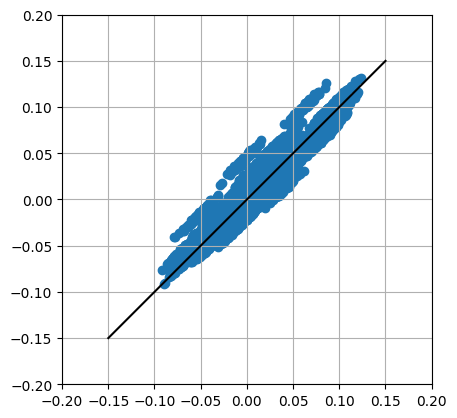

In [133]:
plt.scatter(deki.data.ravel(), delta_params.T.ravel())
#plt.scatter(delta_params2.T.ravel(), delta_params.T.ravel())
plt.plot([-0.15, 0.15], np.array([-0.15, 0.15])*1.0, color='k')
plt.grid()
plt.gca().set_aspect(1)
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])

# Testing Hypotheses
1) Columns of J are correlated. This results in very big steps.
2) Steps are away from the origin (offline trained ANN)

In [67]:
params = np.array(initial_ensemble['param']).astype('float64').T
g_ens =  np.vstack([np.array(initial_ensemble['e_mean']).reshape([initial_ens_size, -1]).astype('float64').T,
                    np.array(initial_ensemble['e_std'] ).reshape([initial_ens_size, -1]).astype('float64').T])

In [80]:
def compute_corr(J):
    print(Gamma_inv.shape, J.shape)
    J_extended = np.hstack([np.sqrt(Gamma_inv)@J, np.sqrt(Gamma_inv)@(y - g_ens[:,0]).reshape([440,1])])
    JJT = J_extended.T@J_extended
    normalization = np.diag(1/np.sqrt(np.diag(JJT)))
    
    np.set_printoptions(precision=2, suppress=True)
    correlation_matrix = (normalization@JJT@normalization)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if i < j:
                correlation_matrix[i,j] = np.nan

    return correlation_matrix

corr_J = compute_corr(J_initial)
corr_K = compute_corr(np.linalg.pinv(K_initial))

(440, 440) (440, 63)
(440, 440) (440, 63)


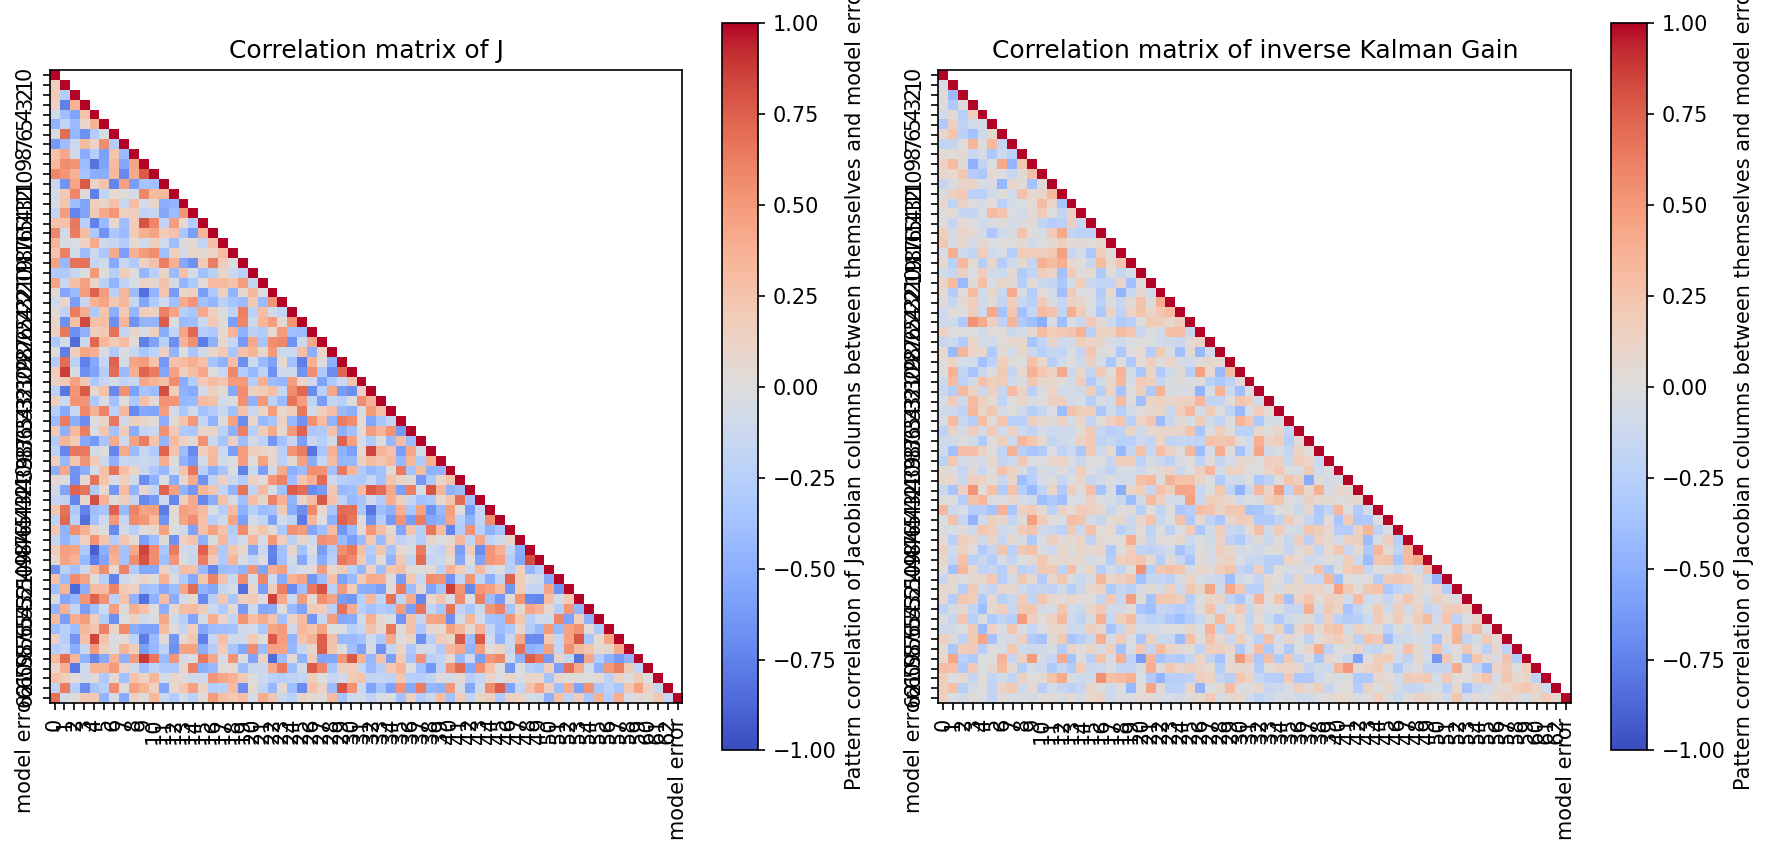

In [85]:
fig = plt.figure(figsize=(12, 10), dpi=150)

plt.subplot(1,2,1)
# Show heatmap
im = plt.imshow(corr_J, cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.colorbar(im, label='Pattern correlation of Jacobian columns between themselves and model error', shrink=0.5)

# Set labels and ticks
plt.xticks(np.arange(64), [j for j in range(63)] + ['model error'], rotation=90)
plt.yticks(np.arange(64), [j for j in range(63)] + ['model error'], rotation=90)
plt.title("Correlation matrix of J")

plt.subplot(1,2,2)
# Show heatmap
im = plt.imshow(corr_K, cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.colorbar(im, label='Pattern correlation of Jacobian columns between themselves and model error', shrink = 0.5)

# Set labels and ticks
plt.xticks(np.arange(64), [j for j in range(63)] + ['model error'], rotation=90)
plt.yticks(np.arange(64), [j for j in range(63)] + ['model error'], rotation=90)
plt.title("Correlation matrix of inverse Kalman Gain")


plt.tight_layout()

# Analysis of covariance matrices

In [16]:
np.linalg.norm(delta_params2.T.ravel() - delta_params.T.ravel())

2.659624716429409

In [17]:
np.linalg.norm(J_initial@cov_xx@J_initial.T - cov_yy) / np.linalg.norm(cov_yy)

0.16295808960350702

In [18]:
np.linalg.norm(J_initial@cov_xx@J_initial.T - cov_yy) / np.linalg.norm(cov_yy)

0.16295808960350702

In [19]:
np.linalg.norm(cov_xx@J_initial.T - cov_xy) / np.linalg.norm(cov_yy)

6.301260983449359e-19

# Alternative Jacobian definition

In [110]:
J_new = cov_yy @ np.linalg.pinv(cov_xy)
np.linalg.norm(J_new@cov_xy-cov_yy) / np.linalg.norm(cov_yy)

0.005978466519640922

In [115]:
#cov_xx_new = np.linalg.pinv(J_new) @ cov_yx
cov_xx_new = cov_xy @ np.linalg.pinv(J_new.T)
np.linalg.norm(J_new @ cov_xx_new - cov_yx) / np.linalg.norm(cov_yx)

0.12796763991667

In [116]:
print(np.linalg.norm(J_new@cov_xx_new@J_new.T - cov_yy) / np.linalg.norm(cov_yy))
print(np.linalg.norm(cov_xx_new@J_new.T - cov_xy) / np.linalg.norm(cov_xy))

0.003106671510306618
0.011500223928171389


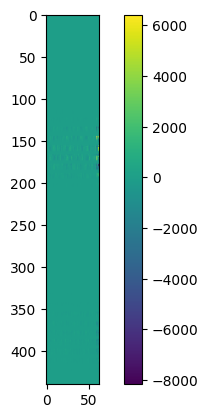

In [86]:
plt.imshow(J_new-J_initial)
plt.colorbar()

In [41]:
np.linalg.norm(J_new@cov_xx_new@J_new.T - cov_yy) / np.linalg.norm(cov_yy)

0.9224037815892915

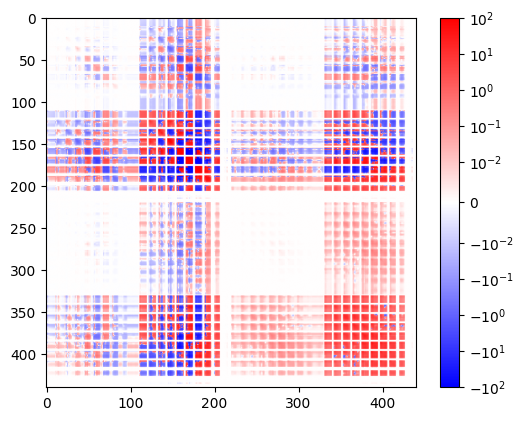

In [151]:
from matplotlib.colors import SymLogNorm
plt.imshow(J_initial@cov_xx@J_initial.T, norm=SymLogNorm(linthresh=1e-2, vmin=-1e+2, vmax=1e+2), cmap='bwr')
plt.colorbar()

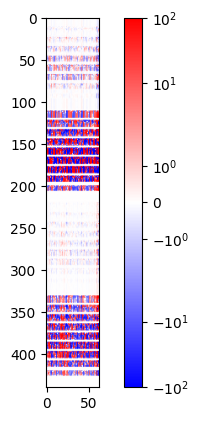

In [176]:
from matplotlib.colors import SymLogNorm
plt.imshow(J_initial, norm=SymLogNorm(linthresh=1+1, vmin=-1e+2, vmax=1e+2), cmap='bwr')
plt.colorbar()

In [ ]:
from matplotlib.colors import SymLogNorm
plt.imshow(np.linalg.pinvJ_initial, norm=SymLogNorm(linthresh=1+1, vmin=-1e+2, vmax=1e+2), cmap='bwr')
plt.colorbar()

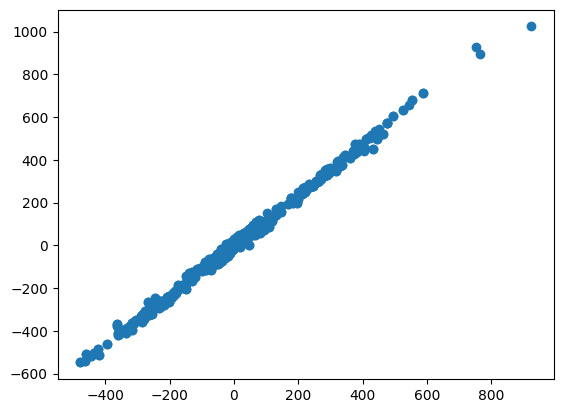

In [155]:
plt.scatter((J_initial@cov_xx@J_initial.T).ravel(), cov_yy.ravel())

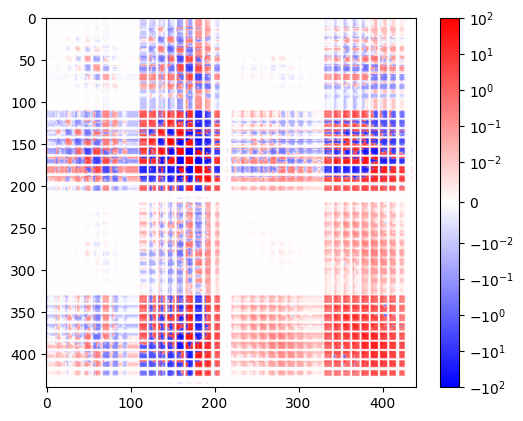

In [72]:
from matplotlib.colors import SymLogNorm
plt.imshow(cov_yy, norm=SymLogNorm(linthresh=1e-2, vmin=-1e+2, vmax=1e+2), cmap='bwr')
plt.colorbar()

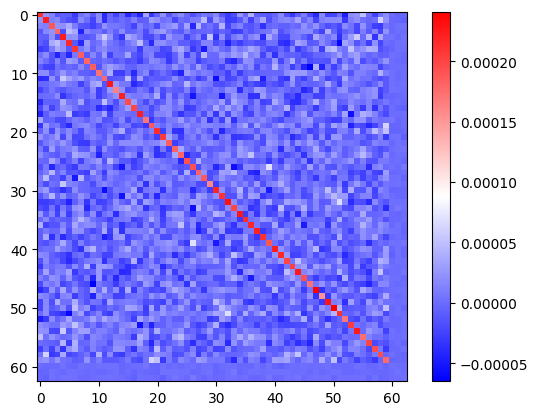

In [80]:
from matplotlib.colors import SymLogNorm, LogNorm
plt.imshow(cov_xx, cmap='bwr')
plt.colorbar()

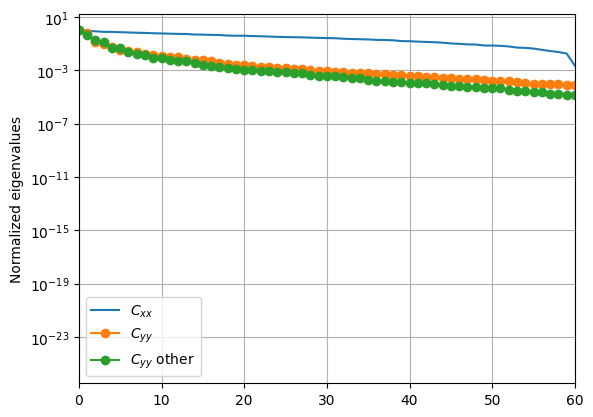

In [261]:
exx = np.sort(np.linalg.eig(cov_xx).eigenvalues)[::-1]
eyy = np.sort(np.linalg.eig(cov_yy).eigenvalues)[::-1]
eyy_other = np.sort(np.linalg.eig((J.T@Gamma_inv@J)).eigenvalues)[::-1]
plt.plot(exx/exx[0], label='$C_{xx}$')
plt.plot(eyy/eyy[0], label='$C_{yy}$', marker='o')
plt.plot(eyy_other/eyy_other[0], label='$C_{yy}$ other', marker='o')
plt.ylabel('Normalized eigenvalues')
plt.xlim([0,60])
plt.legend()
plt.yscale('log')
plt.grid()

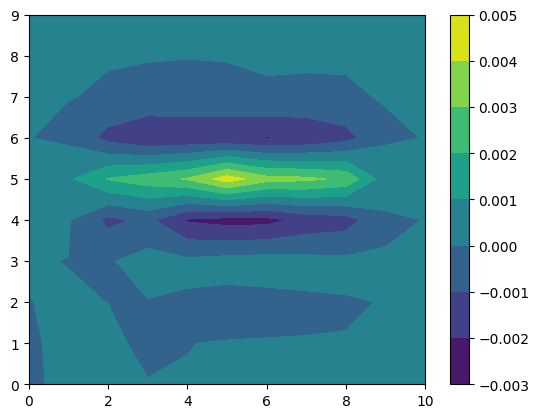

In [122]:
plt.contourf(np.real(np.linalg.eig(cov_yy).eigenvectors[:,0])[:110].reshape([10,11]))
plt.colorbar()

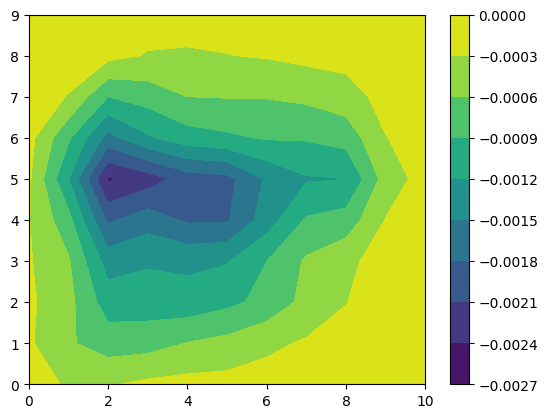

In [172]:
plt.contourf(np.real(np.linalg.eig(cov_yy).eigenvectors[:,3])[220:220+110].reshape([10,11]))
plt.colorbar()

(0.0, 1.0579155019409665)

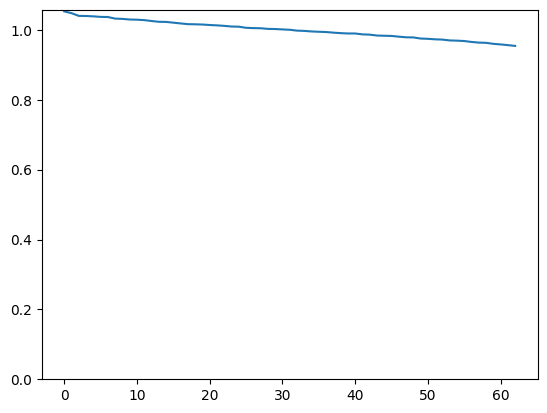

In [150]:
plt.plot(np.sort(np.linalg.eig(np.cov(np.random.randn(63,100000))).eigenvalues)[::-1])
plt.ylim([0,None])

In [136]:
np.sort(np.linalg.eig(np.cov(np.random.randn(63,64))).eigenvalues)[::-1]

array([3.80635994e+00, 3.42398669e+00, 3.17871800e+00, 3.12085637e+00,
       2.82330252e+00, 2.75592437e+00, 2.62674611e+00, 2.55848703e+00,
       2.36309792e+00, 2.32135771e+00, 2.23233323e+00, 2.04950526e+00,
       1.98082826e+00, 1.89852835e+00, 1.76081759e+00, 1.67134259e+00,
       1.60542826e+00, 1.49746515e+00, 1.40568716e+00, 1.37027410e+00,
       1.34337777e+00, 1.29485276e+00, 1.09627437e+00, 1.04343306e+00,
       1.01790087e+00, 9.81188593e-01, 9.04435964e-01, 8.64391852e-01,
       8.39816933e-01, 8.20081869e-01, 6.90528838e-01, 6.68543490e-01,
       6.07217750e-01, 5.94200790e-01, 5.26604123e-01, 5.05895787e-01,
       4.73451457e-01, 4.44688258e-01, 3.91937861e-01, 3.84723226e-01,
       3.22817384e-01, 2.95394253e-01, 2.65188449e-01, 2.53426950e-01,
       2.44192789e-01, 1.79854232e-01, 1.48541114e-01, 1.40570096e-01,
       1.16311307e-01, 1.12229375e-01, 1.11461480e-01, 8.98790458e-02,
       5.82223118e-02, 5.01520098e-02, 4.12426563e-02, 2.88739157e-02,
      

In [323]:
delta_p = np.random.randn(63)
delta_g = np.random.randn(440)

In [324]:
K_new = K + np.outer(delta_p - K@delta_g, Gamma_inv @ delta_g) / np.dot(delta_g, Gamma_inv @ delta_g)

In [327]:
K_new@delta_g - delta_p

array([-5.55111512e-17,  8.32667268e-17, -2.77555756e-17,  0.00000000e+00,
        4.44089210e-16,  0.00000000e+00,  0.00000000e+00, -1.11022302e-15,
       -1.38777878e-16,  0.00000000e+00, -1.11022302e-16,  1.11022302e-16,
        1.11022302e-16, -1.38777878e-17,  1.73472348e-16,  0.00000000e+00,
        2.22044605e-16, -5.55111512e-17, -5.55111512e-17, -2.22044605e-16,
       -2.63677968e-16,  0.00000000e+00, -1.04083409e-17,  0.00000000e+00,
        3.33066907e-16, -2.22044605e-16,  0.00000000e+00,  4.44089210e-16,
        2.22044605e-16,  0.00000000e+00,  1.11022302e-16,  1.11022302e-16,
        1.38777878e-16,  0.00000000e+00,  2.22044605e-16, -4.44089210e-16,
       -1.94289029e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.22044605e-16,
        2.77555756e-17, -5.55111512e-17,  2.22044605e-16,  0.00000000e+00,
       -5.55111512e-17, -2.22044605e-16,  0.00000000e+00, -5.55111512e-17,
        0.00000000e+00, -

In [329]:
K

array([[-1.09404960e-02,  1.98629135e-03, -4.65410735e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.45758571e-03, -3.52732956e-03, -1.13978260e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.35607852e-03, -1.94746578e-03, -1.86551787e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.10378392e-03, -2.47960027e-03,  1.03549979e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.92249595e-04, -2.35575932e-05, -2.46369154e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.33756366e-04,  4.88542380e-04,  1.09056099e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [361]:
delta_g = g_ens - g_ens.mean(-1, keepdims=True)
delta_p = params - params.mean(-1, keepdims=True)
cov_xy = delta_p @ delta_g.T / 100
cov_yy = delta_g @ delta_g.T / 100

delta_p_eki = cov_xy @ np.linalg.pinv(cov_yy+Gamma) @ delta_g
print(np.linalg.norm(delta_p - delta_p_eki) / np.linalg.norm(delta_p))
print(np.linalg.norm(delta_p_eki) / np.linalg.norm(delta_p))
print(np.diag(np.dot(delta_p,delta_p_eki.T)) / np.sqrt(np.diag(np.dot(delta_p,delta_p.T))) / np.sqrt(np.diag(np.dot(delta_p_eki,delta_p_eki.T))))

0.5935047526400526
0.6426414502856738
[0.89707819 0.81843747 0.88898187 0.85130397 0.84585433 0.8261815
 0.89942541 0.82517708 0.80071335 0.87025523 0.8256555  0.84918246
 0.83331705 0.82515481 0.75853011 0.88935648 0.79237439 0.79982735
 0.87668848 0.8492661  0.85131664 0.87555441 0.7916975  0.83251565
 0.89551938 0.78973219 0.80272289 0.90221682 0.80409309 0.80151178
 0.82487363 0.82771707 0.8201552  0.83119979 0.82203925 0.83073446
 0.86980181 0.81442158 0.78954509 0.77388373 0.75928137 0.75995375
 0.89884948 0.80351177 0.78708743 0.7944589  0.8161592  0.81005825
 0.80753265 0.80338815 0.81150149 0.82320158 0.85760231 0.83045115
 0.75805013 0.84120027 0.75835158 0.83613009 0.84794371 0.83762711
 0.84379524 0.79054455 0.77627104]


# secant condition in 1d for simplicity

In [463]:
sigma = 1
x = np.random.randn(100000)
y = x + sigma * np.random.randn(100000)

In [464]:
dx = x - x.mean()
dy = y - y.mean()
cov_xy = np.sum(dx * dy) / 100
cov_yy = np.sum(dy * dy) / 100
K = cov_xy / (cov_yy + sigma**2)

In [465]:
dx_eki = K * dy

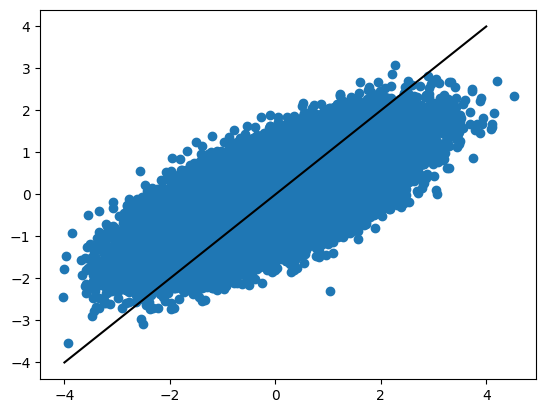

In [466]:
plt.scatter(dx,dx_eki)
plt.plot([-4,4], [-4,4], color='k')

In [511]:
Gamma_chol = np.linalg.cholesky(Gamma)
noise = Gamma_chol @ np.random.randn(440)
np.dot(noise, Gamma_inv@noise)

448.7503094784779